# I- Contexte

Vous êtes consultant Data Analyst dans une entreprise spécialisée dans la data. Votre entreprise a décroché une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM).  

<img src="img/logo_oncfm.png" style="display: block; margin-left: auto; margin-right: auto; width: 100%;"/>   

Cette institution a pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Ils font donc appel à vous, spécialiste de la data, pour mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets et ce à partir simplement de certaines dimensions du billet et des éléments qui le composent. 

Voici le cahier des charges de l’ONCFM [cahier des charges](doc/cahier_des_charges.pdf) ainsi que le jeu de données [billets.csv](data_raw/billets.csv)  

Le client souhaite que vous travailliez directement depuis ses locaux sous la responsabilité de Marie, responsable du projet d’analyse de données à l’ONCFM.  
Elle vous laissera une grande autonomie pendant votre mission, et vous demande simplement que vous lui présentiez vos résultats une fois la mission terminée.   
Elle souhaite voir quels sont les traitements et analyses que vous avez réalisés en amont, les différentes pistes explorées pour la construction de l’algorithme, ainsi que le modèle final retenu.

Après avoir lu en détail le cahier des charges, vous vous préparez à vous rendre à l’ONCFM pour prendre vos nouvelles fonctions. Vous notez tout de même un post-it qui se trouve sur le coin de votre bureau, laissé par un de vos collègues :

In [1]:
# import des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
# Définir les couleurs personnalisées
custom_colors = ['lightgreen', 'lightcoral']
# Créer une colormap personnalisée avec lightgreen et lightcoral
custom_cmap = ListedColormap(['lightgreen', 'lightcoral'])
# Créer un colormap linéaire à partir des couleurs personnalisées
custom_lin_cmap = LinearSegmentedColormap.from_list("CustomCmap", custom_colors, N=256)

# II- Importation des fichiers

In [2]:
# Lecture du fichier avec ; comme séparateur
data = pd.read_csv("data_raw/billets.csv", sep=';')

# Affiche les 5 premières lignes
data.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

# III- Résumé des datas

In [3]:
# On affiche le type de variables, le nombre de valeur pour chacune
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [4]:
# On affiche un résumé des datas notamment avec le nombre de valeurs uniques pour la colonne type bool
data.describe(include="all")

is_genuine     diagonal  height_left  height_right   margin_low  \
count        1500  1500.000000  1500.000000   1500.000000  1463.000000   
unique          2          NaN          NaN           NaN          NaN   
top          True          NaN          NaN           NaN          NaN   
freq         1000          NaN          NaN           NaN          NaN   
mean          NaN   171.958440   104.029533    103.920307     4.485967   
std           NaN     0.305195     0.299462      0.325627     0.663813   
min           NaN   171.040000   103.140000    102.820000     2.980000   
25%           NaN   171.750000   103.820000    103.710000     4.015000   
50%           NaN   171.960000   104.040000    103.920000     4.310000   
75%           NaN   172.170000   104.230000    104.150000     4.870000   
max           NaN   173.010000   104.880000    104.950000     6.900000   

          margin_up      length  
count   1500.000000  1500.00000  
unique          NaN         NaN  
top             NaN         NaN  
freq            NaN         NaN  
mean       3.151473   112.67850  
std        0.231813     0.87273  
min        2.270000   109.49000  
25%        2.990000   112.03000  
50%        3.140000   112.96000  
75%        3.310000   113.34000  
max        3.910000   114.44000

Nous avons un dataframe composé de 7 colonnes et 1 500 lignes  
1 colonne de type boléenne avec 1 000 "True" et 500 "False"  
6 colonnes de type float  
la colonne margin_low ne contient que 14 63 valeurs

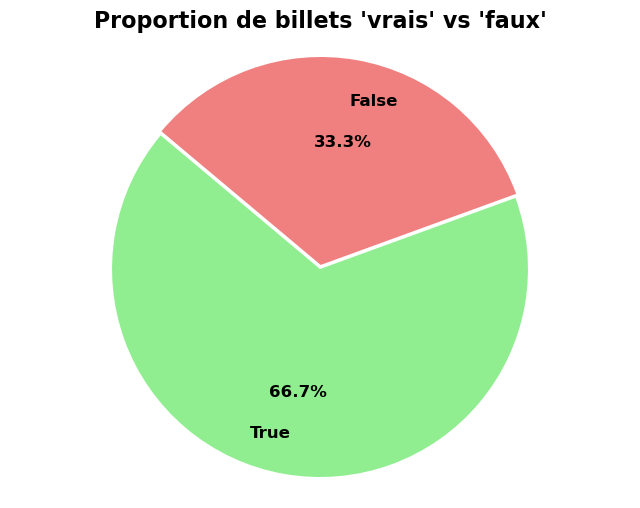

In [5]:
plt.figure(figsize=(8, 6))
counts = data["is_genuine"].value_counts() # compte le nombre de valeurs unique dans la colonne 'is_genuine'
plt.pie(
    counts, # données utilisées pour le pie
    labels=counts.index, # label 'true' ou 'false'
    colors=["lightgreen", "lightcoral"], # couleurs sympa ;-)
    autopct="%1.1f%%", # affiche les pourcentage
    startangle=140, # angle de départ
    explode=(0, 0.02), # Exagération d'une tranche
    labeldistance=0.8, # Distance des labels par rapport au centre
    textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'}  # Propriétés de la police des labels
)
plt.axis("equal")
plt.title("Proportion de billets 'vrais' vs 'faux'", fontsize=16, fontweight='bold', color='black', loc='center')
plt.show()

Je vais stocker les lignes pour lesquelles la colonne margin_low est vide

In [6]:
# création d'un sous dataframe avec uniquement les lignes ou margin_low est vide "NaN"
missing_margin_low = data[data["margin_low"].isna()]

In [7]:
# compte le nombre de ligne de ce sous dataframe
print("il y a ", len(missing_margin_low), "lignes pour lesquelles 'margin_low' est 'NaN'")

il y a  37 lignes pour lesquelles 'margin_low' est 'NaN'


In [8]:
# Imprimer un résumé des dimensions du DataFrame
print("En résumé, nous avons un DataFrame composé :\n",
      f"- de {data.shape[0]} lignes\n",  # Nombre de lignes
      f"- de {data.shape[1]} colonnes\n",  # Nombre de colonnes
      f"- des colonnes : {data.columns.tolist()}\n"  # Liste des noms des colonnes
     )

# Afficher le nombre de types de variables uniques et leur liste
print(f"Il y a {len(data.dtypes.unique())} types de variables : {data.dtypes.unique()}\n")

# Lister les types de données et les colonnes correspondantes
types_uniques = data.dtypes.unique()  # Récupérer les types de données uniques dans le DataFrame
for type_variable in types_uniques:
    # Filtrer les colonnes correspondant à chaque type de données
    colonnes_par_type = data.columns[data.dtypes == type_variable].tolist()
    
    # Afficher le type de données et les colonnes associées
    print(f"La ou les colonnes de type {type_variable} sont : {', '.join(colonnes_par_type)}\n")

# Lister les colonnes contenant des valeurs NaN
colonnes_avec_nan = data.columns[data.isna().any()].tolist()  # Récupérer les colonnes avec des NaN
for miss_val_col in colonnes_avec_nan:
    # Compter le nombre de valeurs manquantes dans la colonne en cours
    miss_val_numb = data[miss_val_col].isna().sum()  
    
    # Afficher le résultat pour la colonne actuelle
    print(f"Dans la colonne '{miss_val_col}', il manque {miss_val_numb} valeurs.\n\n")

En résumé, nous avons un DataFrame composé :
 - de 1500 lignes
 - de 7 colonnes
 - des colonnes : ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

Il y a 2 types de variables : [dtype('bool') dtype('float64')]

La ou les colonnes de type bool sont : is_genuine

La ou les colonnes de type float64 sont : diagonal, height_left, height_right, margin_low, margin_up, length

Dans la colonne 'margin_low', il manque 37 valeurs.




Observons la moyenne de chaque colonne en fonction de la valeur de "is_genuine" "True" ou "False"

In [9]:
colonnes_numeriques = data.select_dtypes(include=['number']).columns.tolist() #récupérer les colonnes numériques
for num_col in colonnes_numeriques:
    true_mean_col = data[data['is_genuine']][num_col].mean() # calcul la moyenne des colonnes pour is_genuine True
    false_mean_col = data[~data['is_genuine']][num_col].mean() # calcul la moyenne des colonnes pour is_genuine False
    print(f"La moyenne de la colonne '{num_col}' pour les valeurs 'True' est : {true_mean_col:.2f}")
    print(f"La moyenne de la colonne '{num_col}' pour les valeurs 'False' est : {false_mean_col:.2f}")

La moyenne de la colonne 'diagonal' pour les valeurs 'True' est : 171.99
La moyenne de la colonne 'diagonal' pour les valeurs 'False' est : 171.90
La moyenne de la colonne 'height_left' pour les valeurs 'True' est : 103.95
La moyenne de la colonne 'height_left' pour les valeurs 'False' est : 104.19
La moyenne de la colonne 'height_right' pour les valeurs 'True' est : 103.81
La moyenne de la colonne 'height_right' pour les valeurs 'False' est : 104.14
La moyenne de la colonne 'margin_low' pour les valeurs 'True' est : 4.12
La moyenne de la colonne 'margin_low' pour les valeurs 'False' est : 5.22
La moyenne de la colonne 'margin_up' pour les valeurs 'True' est : 3.05
La moyenne de la colonne 'margin_up' pour les valeurs 'False' est : 3.35
La moyenne de la colonne 'length' pour les valeurs 'True' est : 113.20
La moyenne de la colonne 'length' pour les valeurs 'False' est : 111.63


Ou sous forme de dataframe pour plus de clarté

In [10]:
resultats = data.groupby("is_genuine").agg(lambda x: x.mean(skipna=True)
                                           if x.dtype in ["float64", "int64"]
                                           else None)
resultats.round(2)

diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False         171.90       104.19        104.14        5.22       3.35  111.63
True          171.99       103.95        103.81        4.12       3.05  113.20

# IV- Remplacement des valeurs manquantes

Nous allons tenter de déterminer les valeurs manquantes de "margin_low" à l'aide des autres variables en réalisant une régression linéaire multiple.

## Régréssion linéaire

On commence par stocker un dataframe sans les lignes ou il y a des valeurs manquantes dans la variable dépendante cad 'margin_low' et on ne conserve que les colonnes numériques

In [11]:
data_without_na = data[~data['margin_low'].isna()].select_dtypes(include=['number'])

In [12]:
data_without_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1463 non-null   float64
 1   height_left   1463 non-null   float64
 2   height_right  1463 non-null   float64
 3   margin_low    1463 non-null   float64
 4   margin_up     1463 non-null   float64
 5   length        1463 non-null   float64
dtypes: float64(6)
memory usage: 80.0 KB


Création du modèle de régression linéaire multiple

In [13]:
# Variables prédictives ou indépendantes
X = data_without_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
# Variables cible ou dépendante
Y = data_without_na['margin_low']
# ajout d'un terme d'interception (intercept) au modèle
X = sm.add_constant(X)
# création du modèle de régression linéaire multiple
model = sm.OLS(Y, X)
# ajustement du modèle
results = model.fit()
# Résumé complet avec les coefficients, p-values...
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          2.60e-202
Time:                        14:32:19   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382   

In [14]:
alpha = 0.05
significant_vars = results.pvalues[(results.pvalues < alpha) & (results.pvalues.index != 'const')]
coef_max_abs = results.params[1:].abs().max()
var_max_name = results.params[1:].abs().idxmax()
coef_max = results.params[var_max_name]

print(f"Le modèle capture une partie importante de la variance, environ {results.rsquared*100:.2f} % mais cela laisse à penser que d'autres facteurs non inclus dans le modèle influencent '{results.model.endog_names}'.\n")  
if not significant_vars.empty:
    print(f"les variables suivantes sont significatives pour la détermination de la variable cible car les p-values sont inférieure au seuil de {alpha}:\n")
    print(significant_vars.to_string(), "\n")
else:
    print(f"Aucune variable n'est significative pour la détermination de la variable cible car les p-values sont supérieur au seuil de {alpha}\n")
print(f"Les 'coef' indiquent l'impact qu'une unité supplémentaire sur la variable indépendante aura sur la variable dépendante.\nOn voit que {var_max_name} a la plus grosse influence avec un coefficient de {coef_max:.2f}.\n\n"
f"Le 'Condition Number' ou 'Cond. No.' est de {results.condition_number:.2f}\n")
if results.condition_number > 30 :
    print(f"C'est un résultat très élevé, ce qui indique une possibilité de multicolinéarité (certaines des variables indép. pourraient être fortement corrélées entre elles).\n")
elif 10< results.condition_number < 30:
    print(f"Ce résultat indique un risque de corrélation modérée, a surveiller")
else:
    print(f"Pas de problème significatif de colinéarité")

print(f"Le test de Durbin-Watson avec un score proche de 2 indique qu'il n'y a probablement pas de forte autocorrélation des résidus (c'est positif pour la validité du modèle).\n")
print(f"Les tests d'Omnibus et Jarque-Bera indique une non-normalité des résidus ce qui pourrait affecter la validité de certaines conclusions.")

Le modèle capture une partie importante de la variance, environ 47.73 % mais cela laisse à penser que d'autres facteurs non inclus dans le modèle influencent 'margin_low'.

les variables suivantes sont significatives pour la détermination de la variable cible car les p-values sont inférieure au seuil de 0.05:

diagonal        7.443859e-03
height_left     4.132146e-05
height_right    2.836546e-09
margin_up       7.233463e-05
length          2.183858e-97 

Les 'coef' indiquent l'impact qu'une unité supplémentaire sur la variable indépendante aura sur la variable dépendante.
On voit que length a la plus grosse influence avec un coefficient de -0.41.

Le 'Condition Number' ou 'Cond. No.' est de 194200.03

C'est un résultat très élevé, ce qui indique une possibilité de multicolinéarité (certaines des variables indép. pourraient être fortement corrélées entre elles).

Le test de Durbin-Watson avec un score proche de 2 indique qu'il n'y a probablement pas de forte autocorrélation des résidus 

Nous allons vérifier s'il y a multicolinéarité des variables indépendantes avec le calcul des VIF (Variance Inflation Factor, Facteur de gonflement de la variance en Français).  
Si une des variables a un VIF très élevé, nous pourrons envisager de la supprimer ou de de combiner les variables fortement corrélées.

In [15]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

In [16]:
vif_data

Variable            VIF
0         const  590198.238883
1      diagonal       1.013613
2   height_left       1.138261
3  height_right       1.230115
4     margin_up       1.404404
5        length       1.576950

Toutes les autres variables ont des VIF inférieurs à 2, ce qui est excellent.  
En général, des VIF supérieurs à 5 (ou parfois 10) sont considérés comme un signe de multicolinéarité problématique, mais ce n'est pas du tout le cas ici.  
Les VIF des variables comme 'diagonal', 'height_left', 'height_right', 'margin_up', et 'length' sont très bas (entre 1 et 1.6), ce qui signifie qu'il y a très peu de multicolinéarité entre elles.  
Cela suggère que les variables ne sont pas fortement corrélées les unes avec les autres, et qu'elles fournissent des informations distinctes.

Puis un autre pré-requis pour la validité d'un modèle de régression linéaire est l'homoscédasticité des résidus.  
Nous allons réaliser le test de Breusch-Pagan pour vérifier qu'il n'y a pas d'hétéroscédasticité.

In [17]:
# on stocke les résidus du modèle dans une variable
residuals = results.resid
# Test de Breusch-Pagan
bp_test = het_breuschpagan(residuals, results.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test[0]}, p-value: {bp_test[1]}")

Breusch-Pagan Test Statistic: 80.16261280174568, p-value: 7.759535216213152e-16


La p-value étant très faible (bien en dessous du seuil de 0.05), cela signifie que nous rejètons l'hypothèse nulle d'homoscédasticité.  
En d'autres termes, il y a hétéroscédasticité dans les résidus du modèle, ce qui signifie que la variance des erreurs n'est pas constante.

Pour résoudre ce problème, nous allons appliquer des transformations aux variables, notamment en utilisant les méthodes de transformation logarithmique, quadratique et inverse.  
Ces transformations visent à stabiliser la variance des résidus et à réduire l'hétéroscédasticité.

En effectuant ces transformations sur certaines variables explicatives et/ou sur la variable dépendante, nous espérons obtenir une distribution d'erreurs plus homogène, ce qui rendra les estimations des coefficients de régression plus robustes.  
Cette approche améliorera ainsi la fiabilité du modèle, tant en termes d'interprétation des coefficients que de validité des tests d'hypothèse.

## Histogramme de la distribution des variables

On peut visualiser la distribution des variables afin d'adapter les transformations à apporter pour la régression linéaire

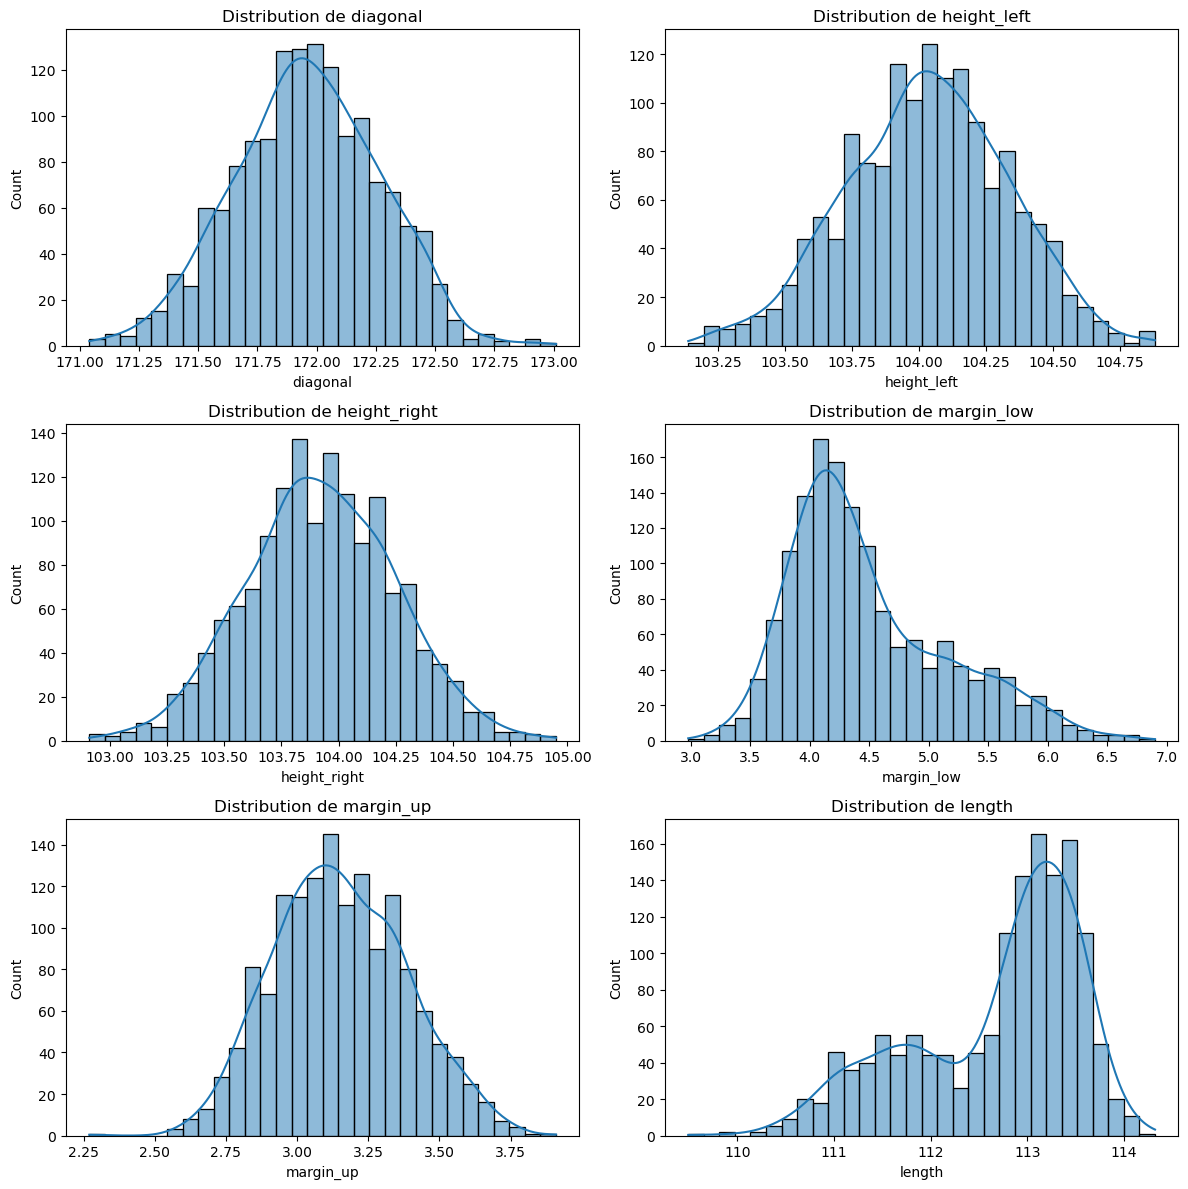

In [18]:
# Définir le nombre de lignes et de colonnes pour l'affichage des graphiques
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 lignes, 2 colonnes

# Aplatir la matrice d'axes pour un accès plus facile dans la boucle
axes = axes.flatten()

for i, num_col in enumerate(colonnes_numeriques):
    sns.histplot(data_without_na[num_col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution de {num_col}")
plt.tight_layout()
plt.show()

Variables avec une distribution gaussienne ==> 'diagonal', 'height_right', 'height_left', 'margin_up' ==> aucune transformation nécessaire  

Variable avec une distribution positivement asymétrique (asymétrique à droite) ==> 'margin_low' ==> transformation logarithmique recommandée pour aider à stabiliser la variance et rendre la distribution plus normale  

Variable avec une distribution négativement asymétrique (asymétrique à gauche) ==> 'length' ==> transformation inverse ou quadratique recommandée pour ajuster la distribution.

## Exploration des transformations

### Transformation logarithmique de margin_low

In [19]:
# Vérification que les valeurs sont positives
if(data_without_na['margin_low'] <= 0).any():
    print("erreur : margin_low contient des valeurs négatives ou nulles, impossible d'applique la transformation logarithmique")
else:
    # transformation log
    data_without_na['log_margin_low'] = np.log(data_without_na['margin_low'])

Observons les différences de distribution

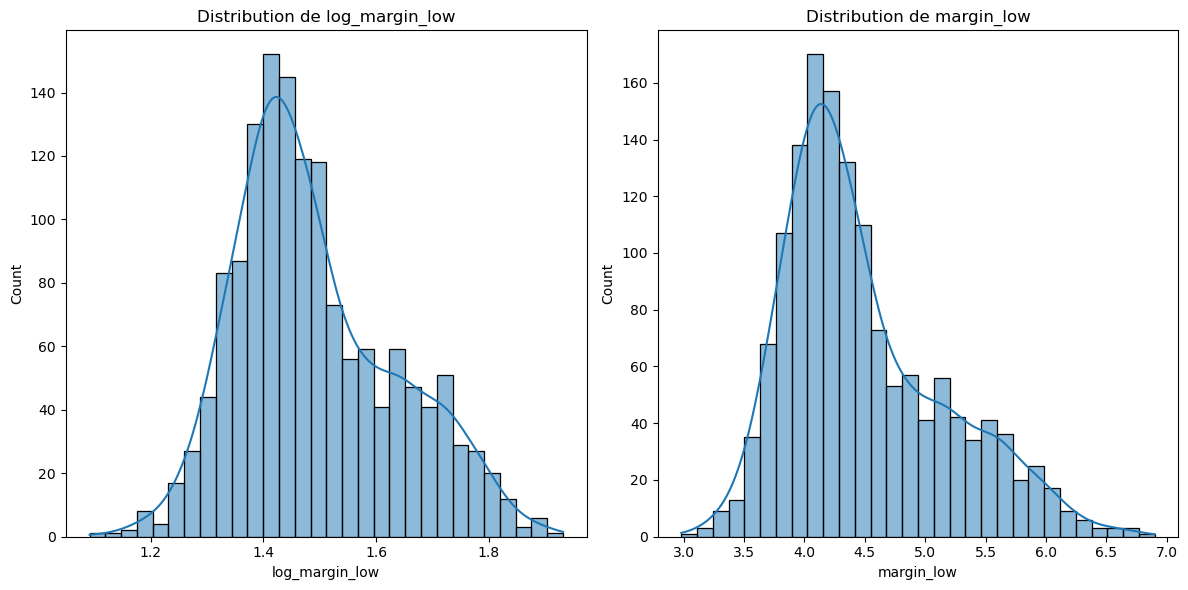

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data_without_na['log_margin_low'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution de log_margin_low")

sns.histplot(data_without_na['margin_low'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution de margin_low")

plt.tight_layout()
plt.show()

Après la transformation logarithmique de margin_low, nous réestimons le modèle pour observer les effets.

In [21]:
# Variables prédictives ou indépendantes, on utilise X avec les variables non transformées ==> "X = data_without_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]"
# Variables cible ou dépendante on utilise la transformation logarithmique de margin_low
Y_log = data_without_na['log_margin_low']
# création du modèle de régression linéaire multiple
model_log = sm.OLS(Y_log, X)
# ajustement du modèle
results_log = model_log.fit()
# Résumé complet avec les coefficients, p-values...
print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:         log_margin_low   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     261.2
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          1.63e-199
Time:                        14:32:21   Log-Likelihood:                 1248.2
No. Observations:                1463   AIC:                            -2484.
Df Residuals:                    1457   BIC:                            -2453.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.0849      2.075      2.451   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [22]:
# on stocke les résidus du modèle dans une variable
residuals_log = results_log.resid
# Test de Breusch-Pagan
bp_test_log = het_breuschpagan(residuals_log, results_log.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_log[0]}, p-value: {bp_test_log[1]}")

Breusch-Pagan Test Statistic: 32.99634607369718, p-value: 3.7697249620147653e-06


In [23]:
if (bp_test_log[1] < 0.05):
    print(f"Avec une p-value de {bp_test_log[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_log[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.0000, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.
Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.


### Transformation inverse de length

In [24]:
# Vérification que les valeurs sont positives
if(data_without_na['length'] <= 0).any():
    print("erreur : length contient des valeurs négatives ou nulles, impossible d'applique la transformation inverse")
else:
    # transformation inverse
    data_without_na['inv_length'] = 1 / data_without_na['length']

Observons les différences de distribution

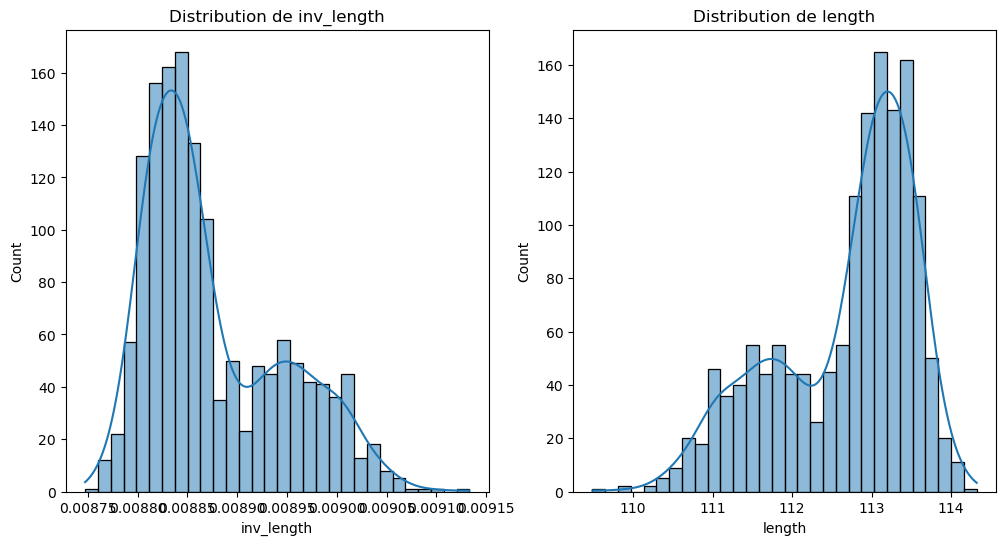

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data_without_na['inv_length'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution de inv_length")

sns.histplot(data_without_na['length'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution de length")

plt.show()

Après la transformation inverse de length, nous réestimons le modèle pour observer les effets.

In [26]:
# Variables prédictives ou indépendantes, on utilise X mais on modifie length pour utiliser son inverse
X_inv_length = data_without_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'inv_length']]
# Variables cible ou dépendante on utilise Y ==> "Y = data_without_na['margin_low']"
# ajout d'un terme d'interception (intercept) au modèle
X_inv_length = sm.add_constant(X_inv_length)
# création du modèle de régression linéaire multiple
model_inv_length = sm.OLS(Y, X_inv_length)
# ajustement du modèle
results_inv_length = model_inv_length.fit()
# Résumé complet avec les coefficients, p-values...
print(results_inv_length.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          2.64e-202
Time:                        14:32:21   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -68.8640      8.990     -7.660   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [27]:
# on stocke les résidus du modèle dans une variable
residuals_inv_length = results_inv_length.resid
# Test de Breusch-Pagan
bp_test_inv_length = het_breuschpagan(residuals_inv_length, results_inv_length.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_inv_length[0]}, p-value: {bp_test_inv_length[1]}")

Breusch-Pagan Test Statistic: 81.28771742087517, p-value: 4.512111915499612e-16


In [28]:
if (bp_test_inv_length[1] < 0.05):
    print(f"Avec une p-value de {bp_test_inv_length[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_inv_length[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.0000, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.
Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.


### Transformation quadratique de length

In [29]:
data_without_na['quad_length'] = data_without_na['length'] ** 2

Observons les différences de distribution

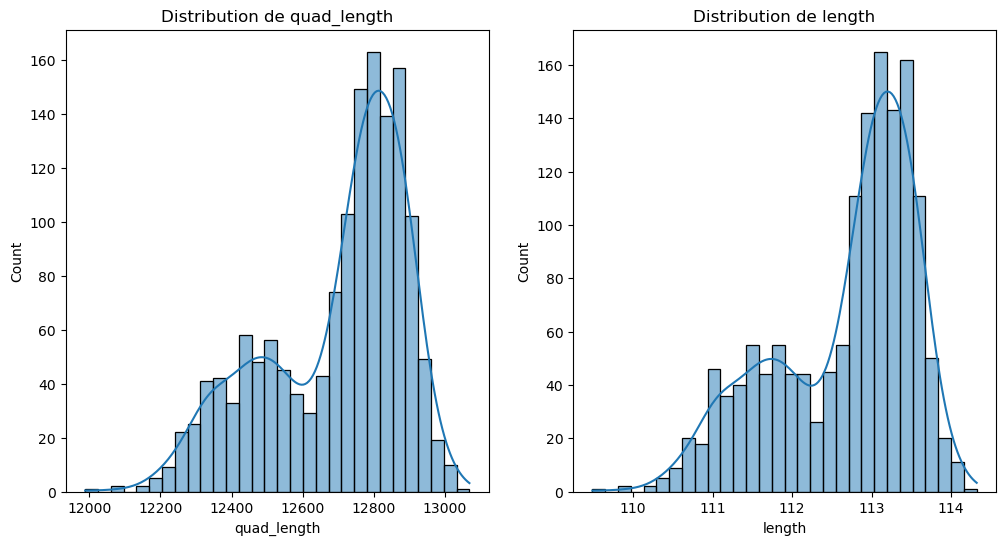

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data_without_na['quad_length'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution de quad_length")

sns.histplot(data_without_na['length'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution de length")

plt.show()

Après la transformation quadratique de length, nous réestimons le modèle pour observer les effets.

In [31]:
# Variables prédictives ou indépendantes, on utilise X mais on modifie length pour utiliser son inverse
X_quad_length = data_without_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'quad_length']]
# Variables cible ou dépendante on utilise Y ==> "Y = data_without_na['margin_low']"
# ajout d'un terme d'interception (intercept) au modèle
X_quad_length = sm.add_constant(X_quad_length)
# création du modèle de régression linéaire multiple
model_quad_length = sm.OLS(Y, X_quad_length)
# ajustement du modèle
results_quad_length = model_quad_length.fit()
# Résumé complet avec les coefficients, p-values...
print(results_quad_length.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          2.66e-202
Time:                        14:32:22   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0013      9.329     -0.000   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [32]:
# on stocke les résidus du modèle dans une variable
residuals_quad_length = results_quad_length.resid
# Test de Breusch-Pagan
bp_test_quad_length = het_breuschpagan(residuals_quad_length, results_quad_length.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_quad_length[0]}, p-value: {bp_test_quad_length[1]}")

Breusch-Pagan Test Statistic: 79.60726005312009, p-value: 1.0139397768230028e-15


In [33]:
if (bp_test_quad_length[1] < 0.05):
    print(f"Avec une p-value de {bp_test_quad_length[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_quad_length[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.0000, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.
Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.


### Transformation logarithmique de margin_low & inverse de length

Observons les différences de distribution

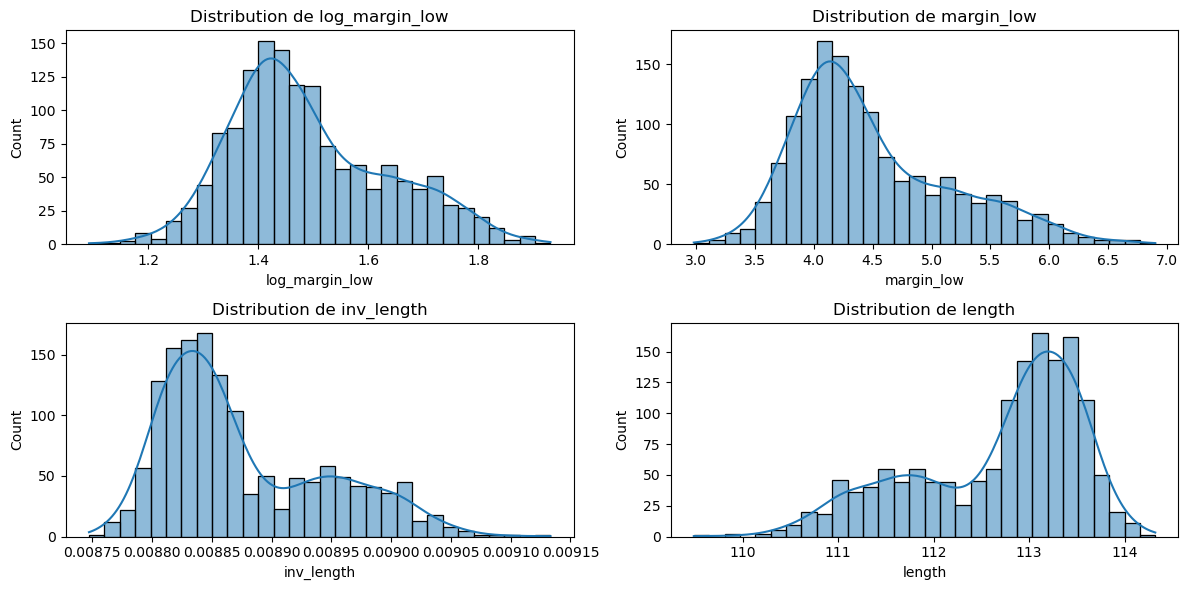

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(data_without_na['log_margin_low'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title("Distribution de log_margin_low")

sns.histplot(data_without_na['margin_low'], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title("Distribution de margin_low")

sns.histplot(data_without_na['inv_length'], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title("Distribution de inv_length")

sns.histplot(data_without_na['length'], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title("Distribution de length")

plt.tight_layout()
plt.show()

Après la transformation logarithmique de margin_low & inverse de length, nous réestimons le modèle pour observer les effets.

In [35]:
# création du modèle de régression linéaire multiple
model_transf = sm.OLS(Y_log, X_inv_length)
# ajustement du modèle
results_transf = model_transf.fit()
# Résumé complet avec les coefficients, p-values...
print(results_transf.summary())

                            OLS Regression Results                            
Dep. Variable:         log_margin_low   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     261.2
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          1.66e-199
Time:                        14:32:22   Log-Likelihood:                 1248.2
No. Observations:                1463   AIC:                            -2484.
Df Residuals:                    1457   BIC:                            -2453.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -14.3864      1.932     -7.446   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [36]:
# on stocke les résidus du modèle dans une variable
residuals_transf = results_transf.resid
# Test de Breusch-Pagan
bp_test_transf = het_breuschpagan(residuals_transf, results_transf.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_transf[0]}, p-value: {bp_test_transf[1]}")

Breusch-Pagan Test Statistic: 33.91283029233985, p-value: 2.4780607258160567e-06


In [37]:
if (bp_test_transf[1] < 0.05):
    print(f"Avec une p-value de {bp_test_transf[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_transf[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.0000, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.
Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.


### Transformation logarithmique de margin_low & quadratique de length

Observons les différences de distribution

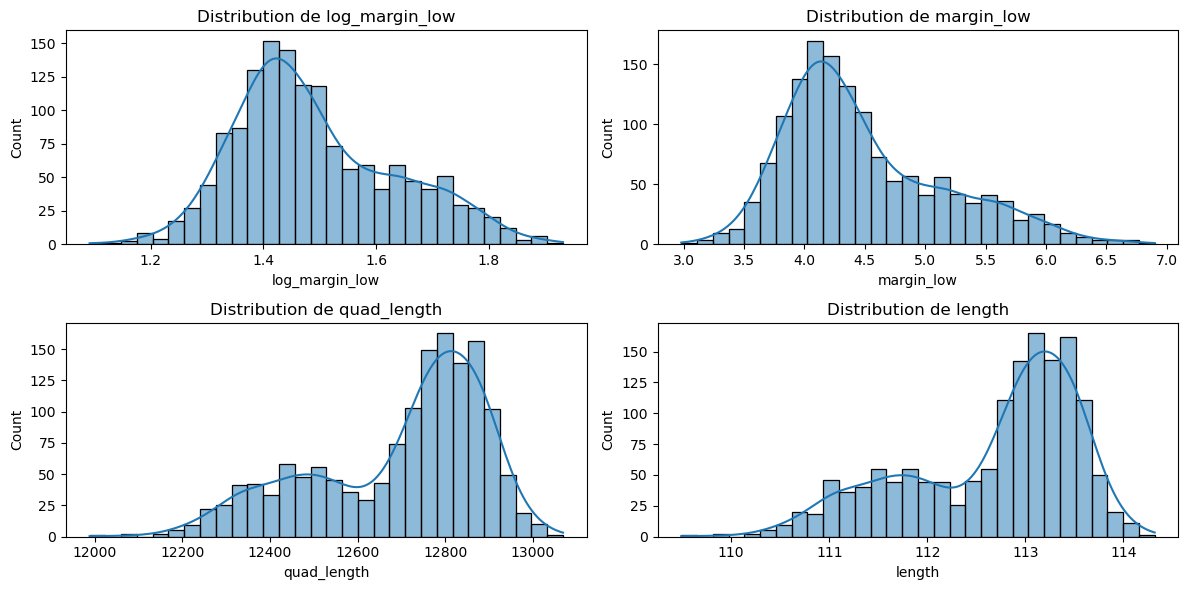

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

sns.histplot(data_without_na['log_margin_low'], bins=30, kde=True, ax=axes[0,0])
axes[0,0].set_title("Distribution de log_margin_low")

sns.histplot(data_without_na['margin_low'], bins=30, kde=True, ax=axes[0,1])
axes[0,1].set_title("Distribution de margin_low")

sns.histplot(data_without_na['quad_length'], bins=30, kde=True, ax=axes[1,0])
axes[1,0].set_title("Distribution de quad_length")

sns.histplot(data_without_na['length'], bins=30, kde=True, ax=axes[1,1])
axes[1,1].set_title("Distribution de length")

plt.tight_layout()
plt.show()

Après la transformation logarithmique de margin_low & quadratique de length, nous réestimons le modèle pour observer les effets.

In [39]:
# création du modèle de régression linéaire multiple
model_transf_2 = sm.OLS(Y_log, X_quad_length)
# ajustement du modèle
results_transf_2 = model_transf_2.fit()
# Résumé complet avec les coefficients, p-values...
print(results_transf_2.summary())

                            OLS Regression Results                            
Dep. Variable:         log_margin_low   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     261.2
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          1.66e-199
Time:                        14:32:23   Log-Likelihood:                 1248.2
No. Observations:                1463   AIC:                            -2484.
Df Residuals:                    1457   BIC:                            -2453.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2105      2.005      0.105   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [40]:
# on stocke les résidus du modèle dans une variable
residuals_transf_2 = results_transf_2.resid
# Test de Breusch-Pagan
bp_test_transf_2 = het_breuschpagan(residuals_transf_2, results_transf_2.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_transf_2[0]}, p-value: {bp_test_transf_2[1]}")

Breusch-Pagan Test Statistic: 32.54734337827223, p-value: 4.628186342260147e-06


In [41]:
if (bp_test_transf_2[1] < 0.05):
    print(f"Avec une p-value de {bp_test_transf_2[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_transf_2[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.0000, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.
Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.


### Transformation inverse de margin_low

In [42]:
# Vérification que les valeurs sont positives
if(data_without_na['margin_low'] <= 0).any():
    print("erreur : margin_low contient des valeurs négatives ou nulles, impossible d'applique la transformation inverse")
else:
    # transformation inverse
    data_without_na['inv_margin_low'] = 1 / data_without_na['margin_low']

Observons les différences de distribution

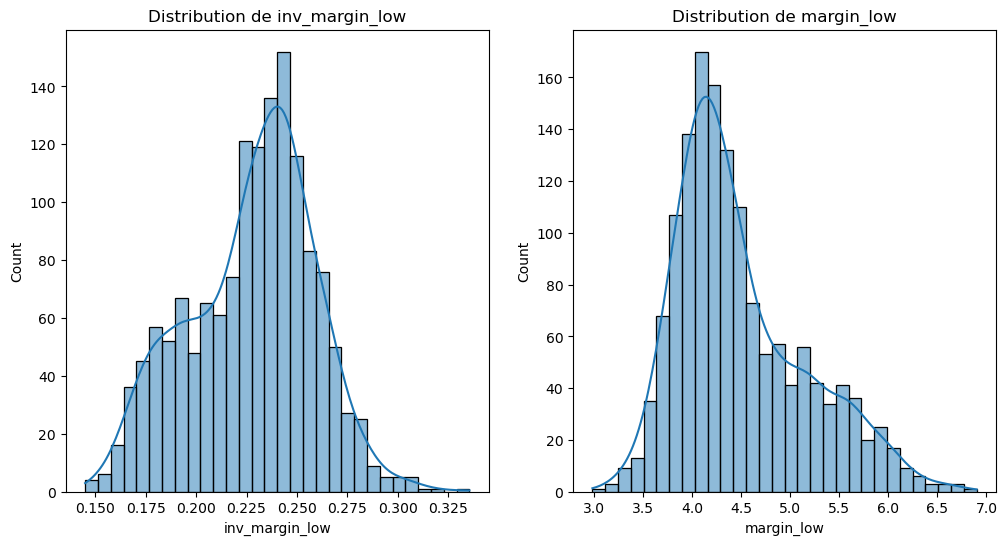

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data_without_na['inv_margin_low'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution de inv_margin_low")

sns.histplot(data_without_na['margin_low'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution de margin_low")

plt.show()

Après la transformation inverse de margin_low, nous réestimons le modèle pour observer les effets.

In [44]:
# Variables prédictives ou indépendantes, on utilise X avec les variables non transformées ==> "X = data_without_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]"
# Variables cible ou dépendante on utilise la transformation inverse de margin_low
Y_inv = data_without_na['inv_margin_low']
# création du modèle de régression linéaire multiple
model_inv = sm.OLS(Y_inv, X)
# ajustement du modèle
results_inv = model_inv.fit()
# Résumé complet avec les coefficients, p-values...
print(results_inv.summary())

                            OLS Regression Results                            
Dep. Variable:         inv_margin_low   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     245.9
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          1.25e-190
Time:                        14:32:23   Log-Likelihood:                 3447.7
No. Observations:                1463   AIC:                            -6883.
Df Residuals:                    1457   BIC:                            -6852.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4655      0.461     -1.009   

Puis on réalise le Test de Breusch-Pagan pour tester l'homoscédasticité

In [45]:
# on stocke les résidus du modèle dans une variable
residuals_inv = results_inv.resid
# Test de Breusch-Pagan
bp_test_inv = het_breuschpagan(residuals_inv, results_inv.model.exog)
# Affichage des résultats
print(f"Breusch-Pagan Test Statistic: {bp_test_inv[0]}, p-value: {bp_test_inv[1]}")

Breusch-Pagan Test Statistic: 4.518978380375212, p-value: 0.47734821871490485


In [46]:
if (bp_test_inv[1] < 0.05):
    print(f"Avec une p-value de {bp_test_inv[1]:.4f}, inférieure au seuil de 0.05, nous rejetons l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Cela signifie qu'il existe des preuves significatives d'hétéroscédasticité, ce qui peut fausser les estimations des erreurs standards des coefficients de régression.\n"
          "Par conséquent, la validité des tests d'hypothèses et des intervalles de confiance est compromise, rendant le modèle dans sa forme actuelle peu fiable.")
else:
    print(f"Avec une p-value de {bp_test_inv[1]:.4f}, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.\n"
          "Il n'y a donc pas de preuves significatives d'hétéroscédasticité.\n"
          "Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.")

Avec une p-value de 0.4773, supérieure au seuil de 0.05, nous ne pouvons pas rejeter l'hypothèse nulle (H0) d'homoscédasticité des résidus.
Il n'y a donc pas de preuves significatives d'hétéroscédasticité.
Ce modèle semble suffisamment fiable pour être utilisé dans une régression linéaire.


![gif_de_fete](img/giphy.webp)

In [47]:
alpha = 0.05
significant_vars = results_inv.pvalues[(results_inv.pvalues < alpha) & (results_inv.pvalues.index != 'const')]
coef_max_abs = results_inv.params[1:].abs().max()
var_max_name = results_inv.params[1:].abs().idxmax()
coef_max = results_inv.params[var_max_name]

print(f"Le modèle capture une partie importante de la variance, environ {results_inv.rsquared*100:.2f} % mais cela laisse à penser que d'autres facteurs non inclus dans le modèle influencent '{results_inv.model.endog_names}'.\n")  
if not significant_vars.empty:
    print(f"les variables suivantes sont significatives pour la détermination de la variable cible car les p-values sont inférieure au seuil de {alpha}:\n")
    print(significant_vars.to_string(), "\n")
else:
    print(f"Aucune variable n'est significative pour la détermination de la variable cible car les p-values sont supérieur au seuil de {alpha}\n")
print(f"Les 'coef' indiquent l'impact qu'une unité supplémentaire sur la variable indépendante aura sur la variable dépendante.\nOn voit que {var_max_name} a la plus grosse influence avec un coefficient de {coef_max:.2f}.\n\n"
f"Le 'Condition Number' ou 'Cond. No.' est de {results.condition_number:.2f}\n")
if results_inv.condition_number > 30 :
    print(f"C'est un résultat très élevé, ce qui indique une possibilité de multicolinéarité (certaines des variables indép. pourraient être fortement corrélées entre elles).\n")
elif 10< results_inv.condition_number < 30:
    print(f"Ce résultat indique un risque de corrélation modérée, a surveiller")
else:
    print(f"Pas de problème significatif de colinéarité")

print(f"Le test de Durbin-Watson avec un score proche de 2 indique qu'il n'y a probablement pas de forte autocorrélation des résidus (c'est positif pour la validité du modèle).\n")
print(f"Les tests d'Omnibus et Jarque-Bera indique une non-normalité des résidus ce qui pourrait affecter la validité de certaines conclusions.")

Le modèle capture une partie importante de la variance, environ 45.76 % mais cela laisse à penser que d'autres facteurs non inclus dans le modèle influencent 'inv_margin_low'.

les variables suivantes sont significatives pour la détermination de la variable cible car les p-values sont inférieure au seuil de 0.05:

diagonal        2.030036e-02
height_left     8.128584e-05
height_right    2.700965e-09
margin_up       7.068436e-05
length          1.071629e-89 

Les 'coef' indiquent l'impact qu'une unité supplémentaire sur la variable indépendante aura sur la variable dépendante.
On voit que length a la plus grosse influence avec un coefficient de 0.02.

Le 'Condition Number' ou 'Cond. No.' est de 194200.03

C'est un résultat très élevé, ce qui indique une possibilité de multicolinéarité (certaines des variables indép. pourraient être fortement corrélées entre elles).

Le test de Durbin-Watson avec un score proche de 2 indique qu'il n'y a probablement pas de forte autocorrélation des résid

Nous avons réalisé une régréssion linéaire avec transformation inverse de la variable dépendante 'margin_low' et nous avons constaté :  
- Que toutes les variables étaient significatives pour déterminer 'margin_low'.  
- Qu'il n'y avait pas de problème de colinéarité entre les variables.
- Que nous avions des résidus homoscédastiques.
- Que notre modèle expliquait près de 45 % de la variance.

Nous allons procéder au remplacement des NaN de la colonne 'margin_low' à l'aide de cette régression linéaire.

## Remplacement des valeurs manquantes

On va utiliser notre modèle retenu 'results_inv' pour prédire les valeurs manquantes de 'margin_low'

In [48]:
data_with_na = data[data['margin_low'].isna()] # On isole la partie de data avec les 37 lignes ou il y a des valeurs manquantes dans margin_low
# Etape 1 : sélection des variables explicatives des lignes avec NaN
X_missing = data_with_na[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
# Ajout d'une constante comme dans notre modèle
X_missing = sm.add_constant(X_missing)
# Etape 2 : Prédiction des valeurs inverses de margin low en utilisant le modèle results_inv
predict_inv = results_inv.predict(X_missing)
# Etape 3 : Transformation des prédictions inverse pour revenir aux valeurs d'"origine"
predict_margin_low = 1 / predict_inv
# Etape 4 : Remplacer les NaN par les predictions dans data 
data.loc[data["margin_low"].isna(), 'margin_low'] = predict_margin_low

Nous pouvons vérifier que les lignes pour lesquelles les valeurs étaient manquantes ont désormais une valeur 'margin_low'

In [49]:
missing_indices = data_with_na.index
data_predicted_raw = data.loc[missing_indices]
data_predicted_raw.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72         True    171.94       103.89        103.45    4.249525       3.25   
99         True    171.93       104.07        104.18    4.319269       3.14   
151        True    172.07       103.80        104.38    4.335315       3.02   
197        True    171.45       103.66        103.80    4.253347       3.62   
241        True    171.83       104.14        104.06    4.545341       3.02   

     length  
72   112.79  
99   113.08  
151  112.93  
197  113.27  
241  112.36

Puis nous pouvons vérifier la cohérence des valeurs de margin_low en comparant la moyenne des valeurs prédites avec le reste du dataframe pour s'assurer que tout est ok

In [50]:
print(f" La moyenne des valeurs prédites est : {data_predicted_raw['margin_low'].mean():.2f}")
print(f" La moyenne des valeurs d'origine est : {data_without_na['margin_low'].mean():.2f}")

 La moyenne des valeurs prédites est : 4.35
 La moyenne des valeurs d'origine est : 4.49


Le résultat est cohérent et assez proche de la moyenne du reste des données.  
Nous pouvons poursuivre et désormais définir un modèle de détection de faux billets.

# V- Construction d'un modèle de prédiction

## Méthodes non supervisées : ACP et clustering K-means pour la détection des faux billets

### Boxplot des variables prédictives

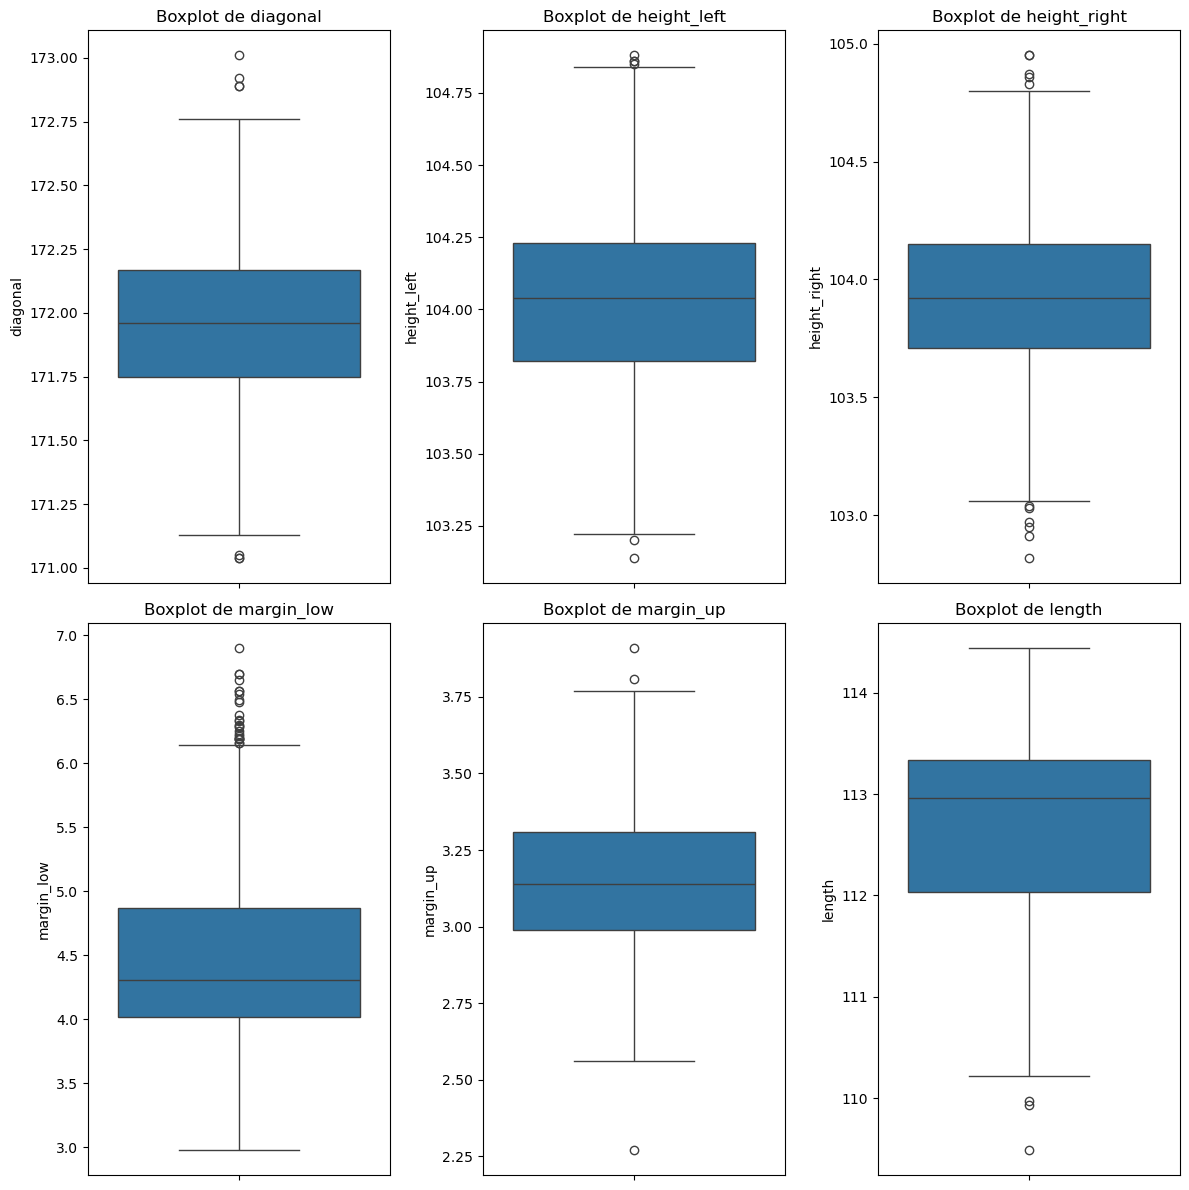

In [51]:
# definition des variables prédictives
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# Créer une figure avec des sous-graphes
fig, axes = plt.subplots(2, 3, figsize=(12, 12))

# Aplatir les axes pour un accès plus facile
axes = axes.flatten()

# boxplot avec seaborn
for i, feat in enumerate(features):
    sns.boxplot(data=data[feat], ax=axes[i])
    axes[i].set_title(f"Boxplot de {feat}")

plt.tight_layout()
plt.show()

### Nuages de points des paires de variables

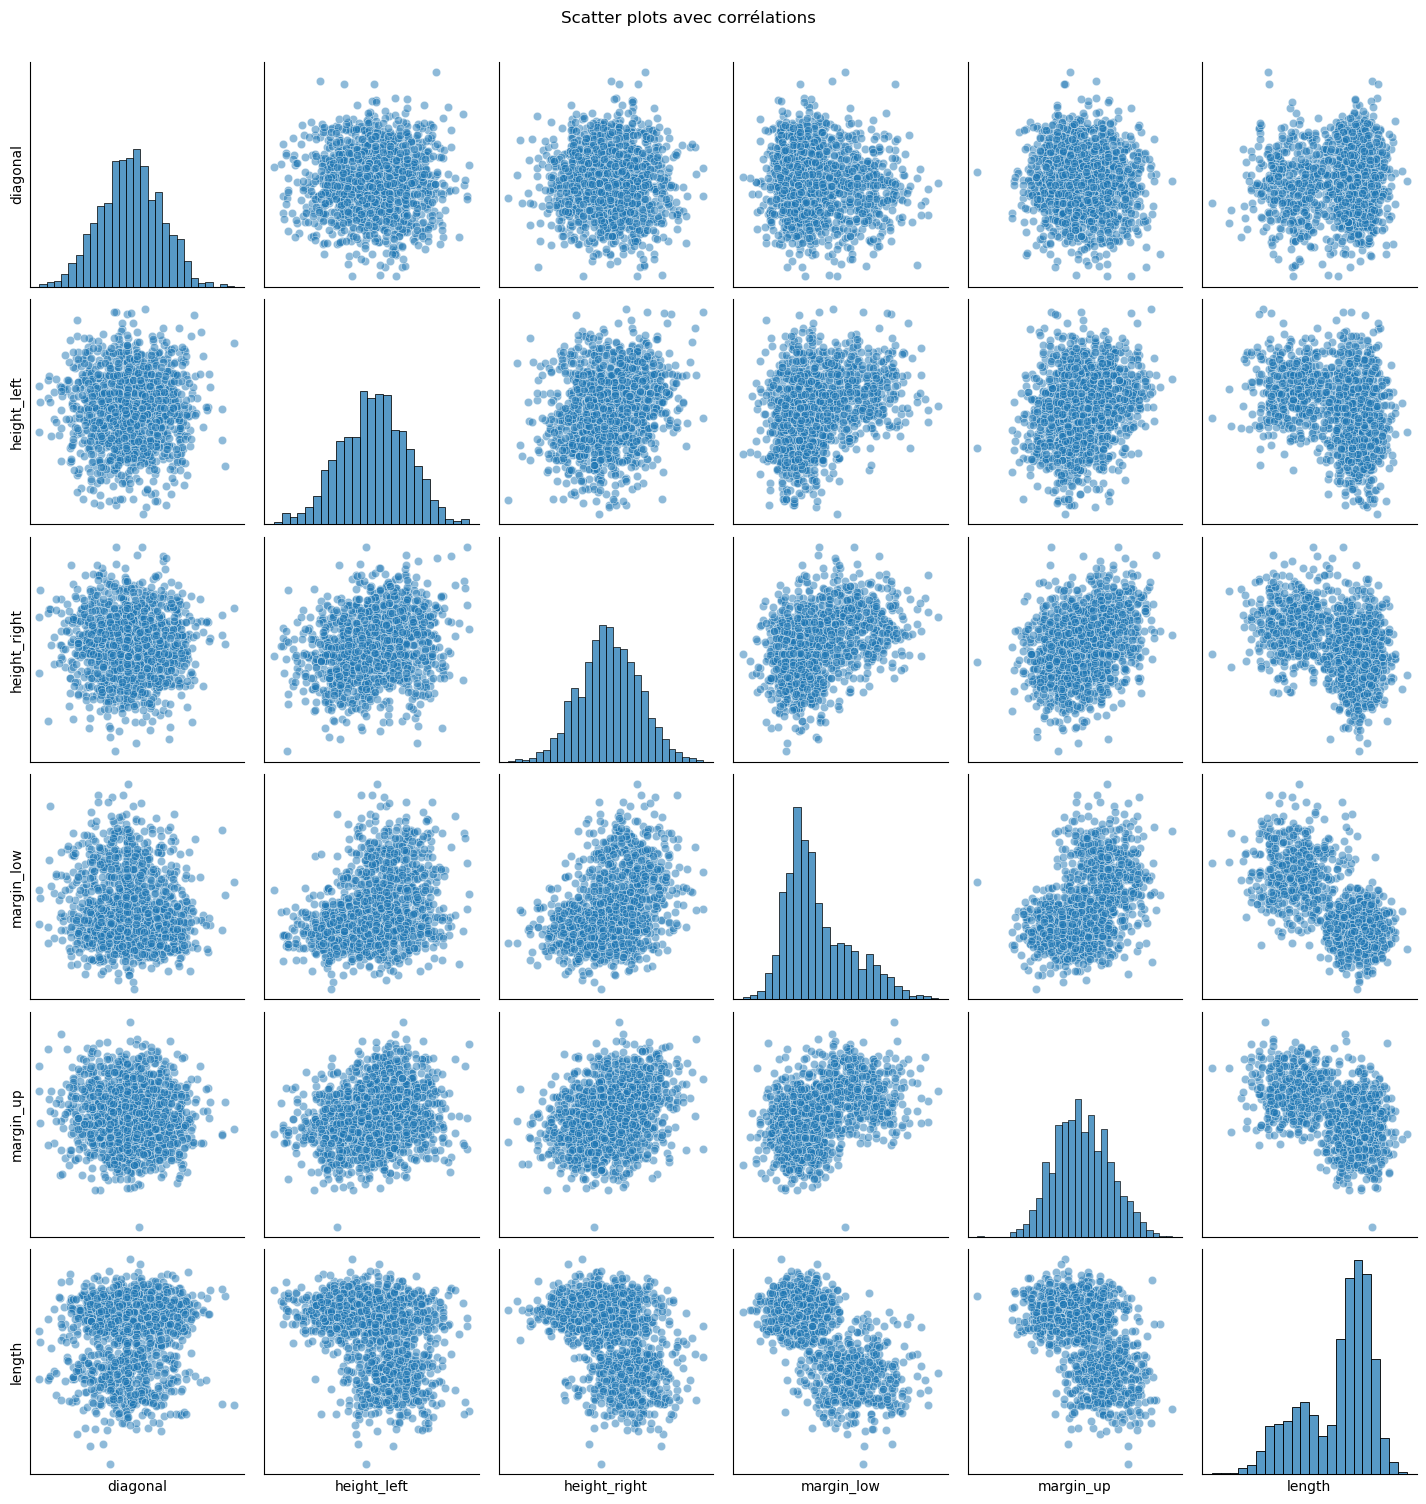

In [52]:
# création de pairplot avec seaborn
pairplot = sns.pairplot(data[features],
                        diag_kind = 'hist', # histogrammes sur la diagonale
                        plot_kws = {'alpha': 0.5}) # ajuster la transparence des points

# Titre
pairplot.fig.suptitle("Scatter plots avec corrélations", y=1.02) # ajustement de la position du titre

# Personnalisation des axes
for ax in pairplot.axes.flatten():
    ax.xaxis.set_tick_params(labelbottom=False) # supprime les étiquettes de l'axe x
    ax.yaxis.set_tick_params(labelleft=False) # supprime les étiquettes de l'axe y
    ax.tick_params(axis='both', which='both', length=0) # supprime les ticks

plt.show()

On remarque quelques corrélations notamment entre les variables 'length' et 'margin_low ou 'lenght' et 'margin_up'.  
Cependant les corrélations ne sont pas évidentes et linéaires.

### Méthode du Z-score pour détecter les valeurs atypiques

In [53]:
# création d'une fonction pour détecter les outliers
def detect_outliers_zscore(df, threshold=3):
    outliers = {}
    for column in df.select_dtypes(include=['float64', 'int']).columns:
        # calcul du zscore
        z_scores = np.abs(stats.zscore(df[column].dropna()))
        # detection outliers
        outliers[column] = df[column][z_scores > threshold]
    return outliers

data_outliers = detect_outliers_zscore(data)

# Afficher le nombre total d'outliers
total_outliers = sum(len(v) for v in data_outliers.values())  # Compte total d'outliers
print(f"Il y a {total_outliers} lignes contenant des outliers.\n")

# Affichage des outliers pour chaque variable
for feat, outliers in data_outliers.items():
    print(f"Outliers pour la variable {feat} :\n")
    print(outliers, "\n________________________\n")

all_indices_outliers = set()

for outliers in data_outliers.values():
    indices_outliers = outliers.index.tolist()
    all_indices_outliers.update(indices_outliers)

all_indices_outliers = sorted(list(all_indices_outliers))
print(f"Indices des outliers : {all_indices_outliers}")

Il y a 24 lignes contenant des outliers.

Outliers pour la variable diagonal :

729     171.04
828     172.92
842     172.89
1022    172.89
1142    171.04
1277    173.01
Name: diagonal, dtype: float64 
________________________

Outliers pour la variable height_left :

Series([], Name: height_left, dtype: float64) 
________________________

Outliers pour la variable height_right :

0       104.95
251     102.82
522     102.91
1484    104.95
Name: height_right, dtype: float64 
________________________

Outliers pour la variable margin_low :

1027    6.70
1041    6.65
1110    6.56
1124    6.70
1169    6.48
1254    6.49
1290    6.90
1441    6.56
1464    6.54
Name: margin_low, dtype: float64 
________________________

Outliers pour la variable margin_up :

664     2.27
1029    3.91
Name: margin_up, dtype: float64 
________________________

Outliers pour la variable length :

1082    109.49
1355    109.97
1453    109.93
Name: length, dtype: float64 
________________________

Indices des outl

### Suppression des lignes d'outliers pour ACP et Clustering

In [54]:
data_without_outliers = data[~data.index.isin(all_indices_outliers)] # On sélectionne les lignes de data dont les indices ne sont pas dans 'all_indices_outliers'

In [55]:
data_without_outliers.info() # on vérifie la composition du dataframe et on constate qu'il y a bien eu 24 lignes supprimées

<class 'pandas.core.frame.DataFrame'>
Index: 1476 entries, 1 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1476 non-null   bool   
 1   diagonal      1476 non-null   float64
 2   height_left   1476 non-null   float64
 3   height_right  1476 non-null   float64
 4   margin_low    1476 non-null   float64
 5   margin_up     1476 non-null   float64
 6   length        1476 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 82.2 KB


Pour l'ACP nous ne conserverons que les colonnes numériques et supprimons 'is_genuine'  
Le but final étant d'observer le résultat d'une classification non supervisée pour déterminer 'is_genuine' en fonction des dimensions

In [56]:
data_acp = data_without_outliers.select_dtypes(include=[np.number]) # On exclu les colonnes non numériques
data_acp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1476 entries, 1 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1476 non-null   float64
 1   height_left   1476 non-null   float64
 2   height_right  1476 non-null   float64
 3   margin_low    1476 non-null   float64
 4   margin_up     1476 non-null   float64
 5   length        1476 non-null   float64
dtypes: float64(6)
memory usage: 80.7 KB


### ACP ou Analyse en Composante Principale

#### Matrice des coefficients de chargement des composantes principales

In [57]:
# Chargement des données et prétraitement
X = data_acp.values  # Convertir le DataFrame en une matrice NumPy X avec les valeurs de data_acp

# Standardisation des données
scaler = StandardScaler()  # Initialiser le scaler
X_scaled = scaler.fit_transform(X)  # Appliquer la standardisation aux données
                                    # Cette fonction centre en soustrayant la moyenne de chaque variable ce qui donnera une moyenne à 0
                                    # Puis cela réduit en divisant par l'écart-type de chaque variable ce qui donnera un écart-type de 1

# Analyse en composantes principales (PCA)
pca = PCA(n_components=len(features))  # Initialiser l'objet PCA avec le nombre de composantes
pca.fit(X_scaled)  # Appliquer PCA aux données standardisées

# Calcul des variances expliquées
scree = (pca.explained_variance_ratio_ * 100).round(2)  # Variance expliquée en pourcentage
scree_cum = scree.cumsum().round()  # Variance expliquée cumulative
x_list = range(1, len(features) + 1)  # Liste des composantes principales

# Récupération des composantes principales
pcs = pca.components_  # Composantes principales
pcs = pd.DataFrame(pcs)  # Convertir en DataFrame pour une meilleure lisibilité
pcs.columns = features  # Nommer les colonnes avec les noms des caractéristiques
pcs.index = [f"F{i}" for i in x_list]  # Nommer les lignes avec les numéros de composante F1, F2 etc...
pcs_rounded = pcs.round(2)  # Arrondir les valeurs à deux décimales

# Transposer les composantes principales pour une meilleure lisibilité
pcs_T = pcs.T  # Transposer le DataFrame des composantes principales

# Affichage du résultat final (pcs_T) dans la cellule suivante
print("DataFrame des composantes principales transposé :\nCoefficients de contribution (ou poids) associés à chaque variable dans chaque composante principale\nPlus la valeur est élevée (en valeur absolue), plus cette variable contribue fortement à la composante principale en question")
pcs_T

DataFrame des composantes principales transposé :
Coefficients de contribution (ou poids) associés à chaque variable dans chaque composante principale
Plus la valeur est élevée (en valeur absolue), plus cette variable contribue fortement à la composante principale en question


F1        F2        F3        F4        F5        F6
diagonal      0.079616  0.944375 -0.278841 -0.091578 -0.124891  0.009019
height_left  -0.332305  0.304630  0.884187 -0.006158  0.122242  0.002442
height_right -0.391382  0.086105 -0.200105  0.868408  0.212390  0.011062
margin_low   -0.508073 -0.075044 -0.089874 -0.112756 -0.562378  0.631799
margin_up    -0.440364  0.007727 -0.270639 -0.438783  0.715766  0.167102
length        0.527254  0.047449  0.138187  0.179441  0.309451  0.756768

#### Eboulis des valeurs propres et Heatmap des coefficients de chargement de l'ACP

Nous allons maintenant observer l'éboulis des valeurs propres et observer le tableau précédent sous forme d'une Heatmap

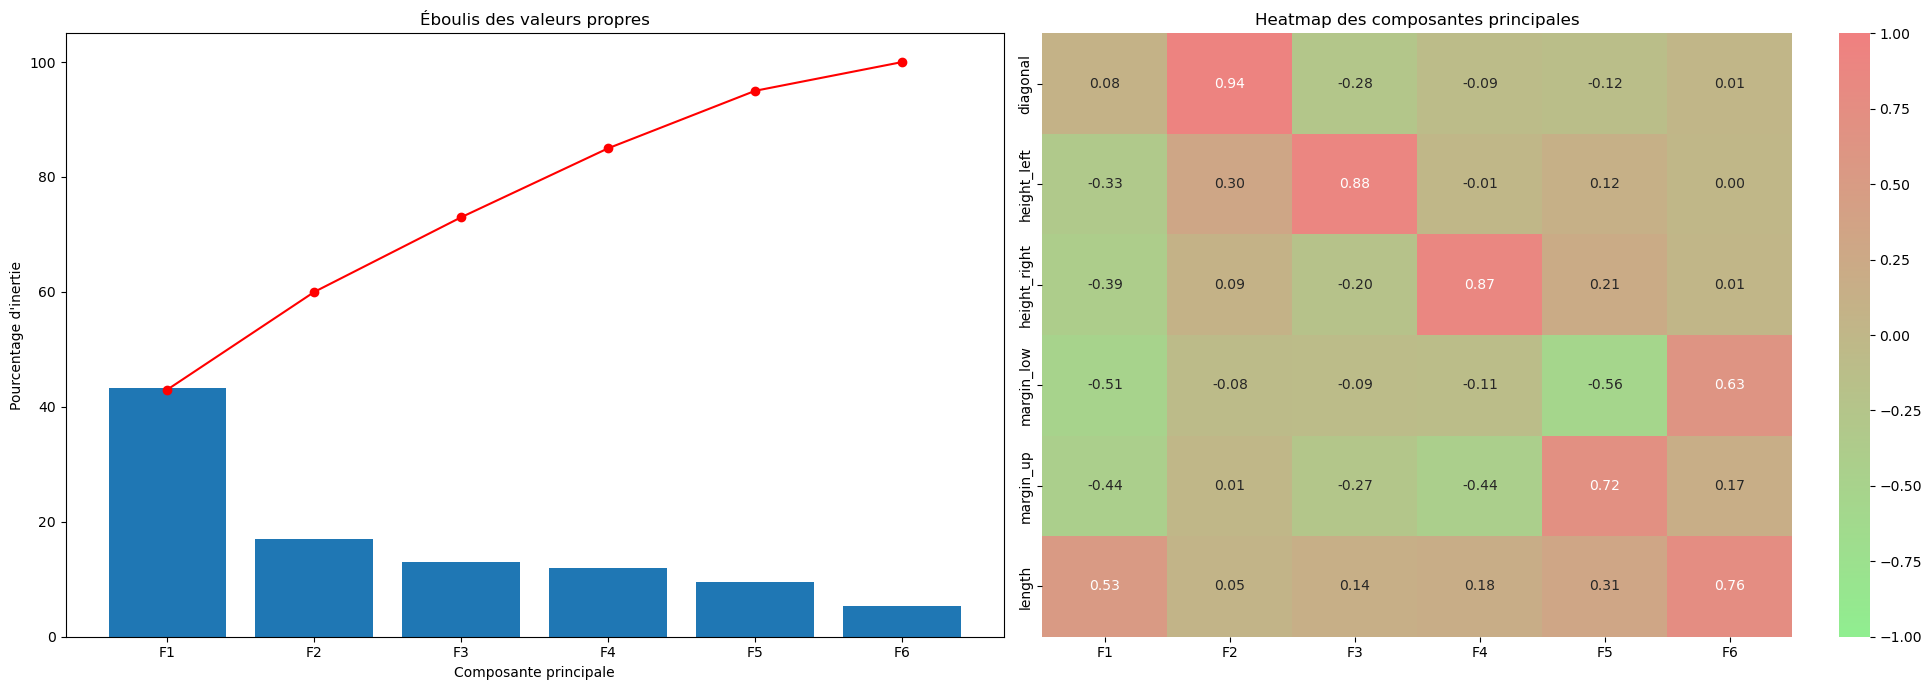

In [58]:
# Création des étiquettes pour les axes d'inertie
x_labels = pcs.index
y_labels = pcs_T.index
# Créer une figure et des axes pour les sous-plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot 1: Scree plot
axes[0].bar(x_list, scree)
axes[0].plot(x_list, scree_cum, c="red", marker='o')
axes[0].set_xticks(x_list)
axes[0].set_xticklabels(x_labels)
axes[0].set_xlabel("Composante principale")
axes[0].set_ylabel("Pourcentage d'inertie")
axes[0].set_title("Éboulis des valeurs propres")

# Plot 2: Heatmap
sns.heatmap(
    pcs_T, 
    vmin=-1, 
    vmax=1, 
    annot=True, 
    cmap=custom_lin_cmap, 
    fmt="0.2f", 
    ax=axes[1], 
    yticklabels=y_labels, 
    xticklabels=x_labels
)
axes[1].set_title("Heatmap des composantes principales")

plt.tight_layout()
plt.show()

#### Transformation des données avec l'ACP

Je choisis de conserver 3 composantes principales  
Elles me permettent d'expliquer près de 80% de la variance et cela me permettra de faciliter la visualisation avec un nuage de points en 3D intéractif

In [59]:
n_components = 3  # Nombre de composantes principales à extraire
pca_3d = PCA(n_components=n_components)  # Initialiser l'objet PCA avec le nombre de composantes
pca_3d.fit(X_scaled)  # Appliquer PCA aux données standardisées

x_list_3d = range(1, n_components + 1)  # Liste des composantes principales

# Récupération des composantes principales
pcs_3d = pca_3d.components_  # Composantes principales
pcs_3d = pd.DataFrame(pcs_3d)  # Convertir en DataFrame pour une meilleure lisibilité
pcs_3d.columns = features  # Nommer les colonnes avec les noms des caractéristiques
pcs_3d.index = [f"F{i}" for i in x_list_3d]  # Nommer les lignes avec les numéros de composante
pcs_3d_rounded = pcs_3d.round(2)  # Arrondir les valeurs à deux décimales

composantes_no_3d = pcs_3d.index # Stock le nom des composantes retenues

# Transposer les composantes principales pour une meilleure lisibilité
pcs_T_3d = pcs_3d.T  # Transposer le DataFrame des composantes principales

# Affichage du résultat final (pcs_T) dans la cellule suivante
print("DataFrame des composantes principales transposé :")
pcs_T_3d

DataFrame des composantes principales transposé :


F1        F2        F3
diagonal      0.079616  0.944375 -0.278841
height_left  -0.332305  0.304630  0.884187
height_right -0.391382  0.086105 -0.200105
margin_low   -0.508073 -0.075044 -0.089874
margin_up    -0.440364  0.007727 -0.270639
length        0.527254  0.047449  0.138187

Nous projetons les valeurs standardisées sur les composantes principales dans une matrice X_projection_3d, qui contient les coordonnées des 1476 individus issus de data_acp après transformation par PCA.

In [60]:
X_projection_3d = pca_3d.transform(X_scaled)

#### Cercle des Corrélations et Projection des Individus sur les Composantes Principales

In [61]:
# Fonction pour dessiner le cercle des corrélations
def correlation_circle(pca, features, ax, dim1=0, dim2=1):
    """
    Trace le cercle des corrélations pour une analyse en composantes principales (PCA).
    
    Parameters:
    - pca: L'objet PCA qui contient les composantes principales et la variance expliquée.
    - features: Liste des noms des caractéristiques d'origine.
    - ax: Axes de Matplotlib pour tracer le cercle des corrélations.
    - dim1: Indice de la première dimension à tracer (par défaut 0 pour F1).
    - dim2: Indice de la deuxième dimension à tracer (par défaut 1 pour F2).
    
    Returns:
    - None: La fonction trace directement sur les axes fournis.
    """
    pcs = pca.components_
    n_pcs = len(pcs)
    
    # Plot circle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    ax.add_artist(circle)
    
    for i, (x, y) in enumerate(zip(pcs[dim1, :], pcs[dim2, :])):
        ax.arrow(0, 0, x, y, head_width=0.1, head_length=0.1, fc='orange', ec='orange')
        ax.text(x * 1.15, y * 1.15, features[i], color='black', ha='center', va='center')

    ax.set_xlabel(f'F{dim1 + 1} ({round(100 * pca.explained_variance_ratio_[dim1], 2)}%)')
    ax.set_ylabel(f'F{dim2 + 1} ({round(100 * pca.explained_variance_ratio_[dim2], 2)}%)')
    
    # Calculer les limites dynamiques
    x_max = np.max(np.abs(pcs[dim1, :]))
    y_max = np.max(np.abs(pcs[dim2, :]))
    lim = max(x_max, y_max) * 1.2  # Ajouter une marge de 10%

    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.set_aspect('equal')    # Ensure the plot is square
    ax.axis('on')             # Display axes
    ax.axhline(0, color='gray', linestyle='--')  # Horizontal line at y=0
    ax.axvline(0, color='gray', linestyle='--')  # Vertical line at x=0

# Fonction pour dessiner la projection des individus
def factorial_planes(X_projection, pca, ax, dim1=0, dim2=1):
    """
    Trace les projections des individus sur les plans factoriels de l'ACP.
    
    Parameters:
    - X_projection: Les données projetées sur les composantes principales.
    - pca: L'objet PCA qui contient la variance expliquée par chaque composante.
    - ax: Axes de Matplotlib pour tracer les projections des individus.
    - dim1: Indice de la première dimension à tracer (par défaut 0 pour F1).
    - dim2: Indice de la deuxième dimension à tracer (par défaut 1 pour F2).
    
    Returns:
    - None: La fonction trace directement sur les axes fournis.
    """
    ax.scatter(X_projection[:, dim1], X_projection[:, dim2], alpha=0.6)
    ax.set_xlabel(f'F{dim1 + 1} ({round(100 * pca.explained_variance_ratio_[dim1], 2)}%)')
    ax.set_ylabel(f'F{dim2 + 1} ({round(100 * pca.explained_variance_ratio_[dim2], 2)}%)')
    ax.grid()

Nous pouvons observer le nuage des individus sur un plan factoriel en 2D, constitué d'une paire de composantes principales, et analyser leur positionnement par rapport au cercle des corrélations associé.

##### F1 & F2

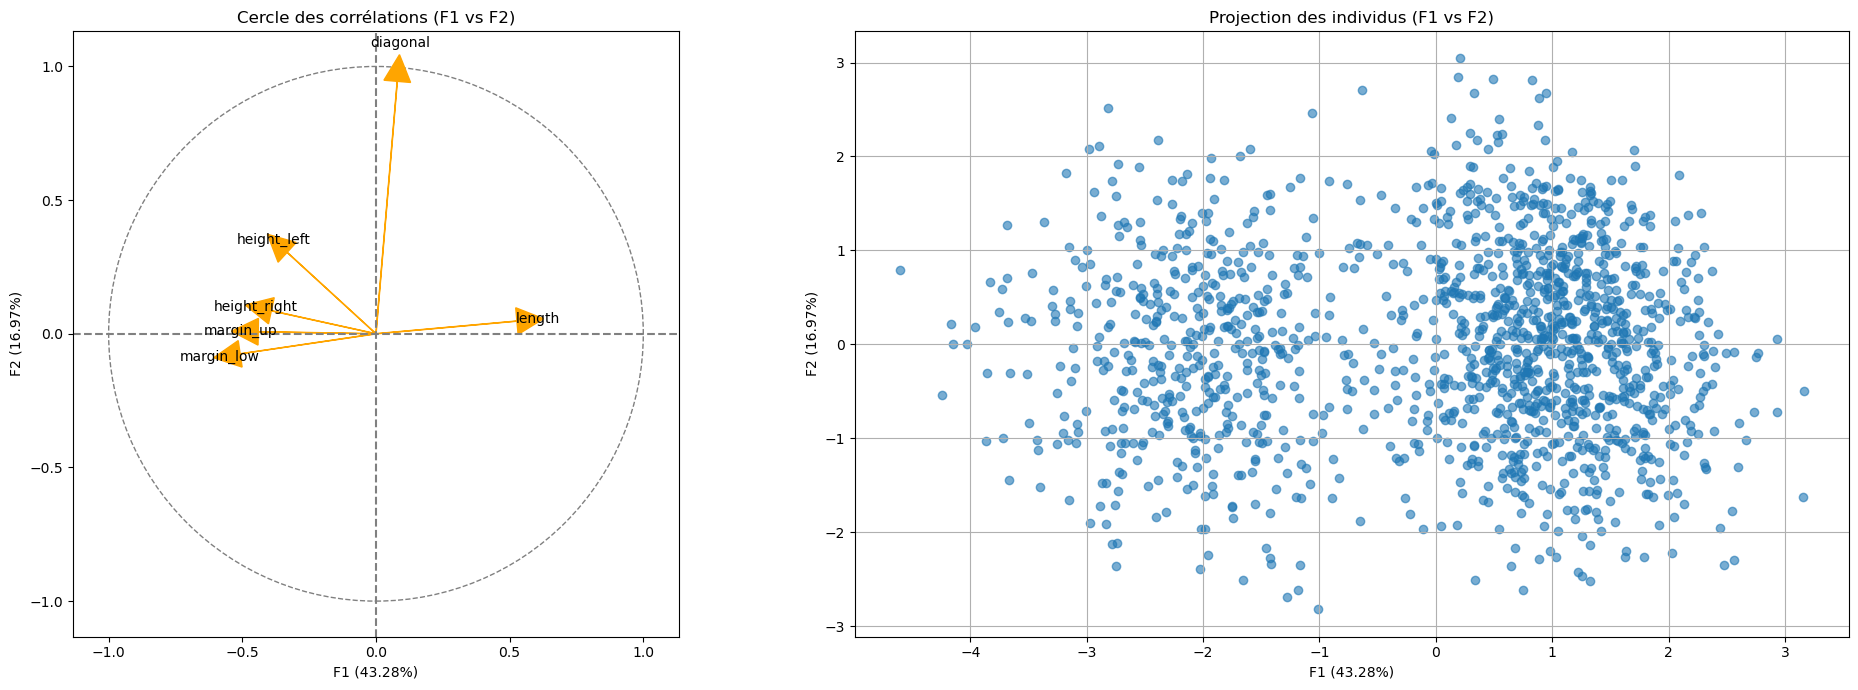

In [62]:
# Créer une figure et des axes pour les sous-plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot 3: Correlation circle (Cercle des corrélations)
correlation_circle(pca_3d, features, ax=axes[0], dim1=0, dim2=1)  # F1 and F2
axes[0].set_title("Cercle des corrélations (F1 vs F2)")

# Plot 4: Factorial planes (Projection des individus)
factorial_planes(X_projection_3d, pca_3d, ax=axes[1], dim1=0, dim2=1)  # F1 and F2
axes[1].set_title("Projection des individus (F1 vs F2)")

plt.tight_layout()
plt.show()

##### F1 & F3

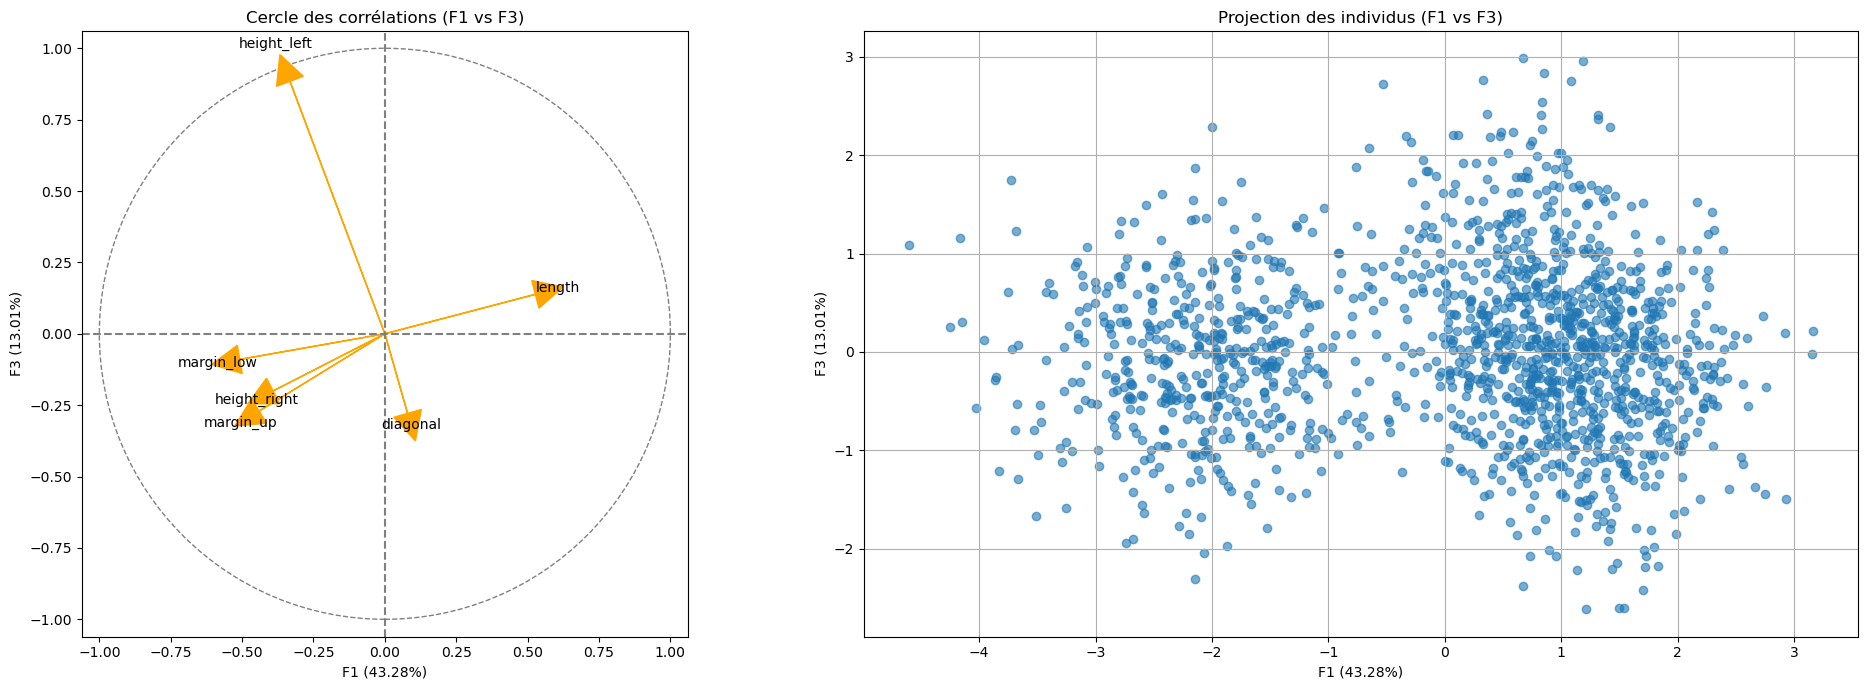

In [63]:
# Créer une figure et des axes pour les sous-plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Correlation circle (Cercle des corrélations)
correlation_circle(pca_3d, features, ax=axes[0], dim1=0, dim2=2)  # F1 and F3
axes[0].set_title("Cercle des corrélations (F1 vs F3)")

# Factorial planes (Projection des individus)
factorial_planes(X_projection_3d, pca_3d, ax=axes[1], dim1=0, dim2=2)  # F1 and F3
axes[1].set_title("Projection des individus (F1 vs F3)")

plt.tight_layout()
plt.show()

##### F2 & F3

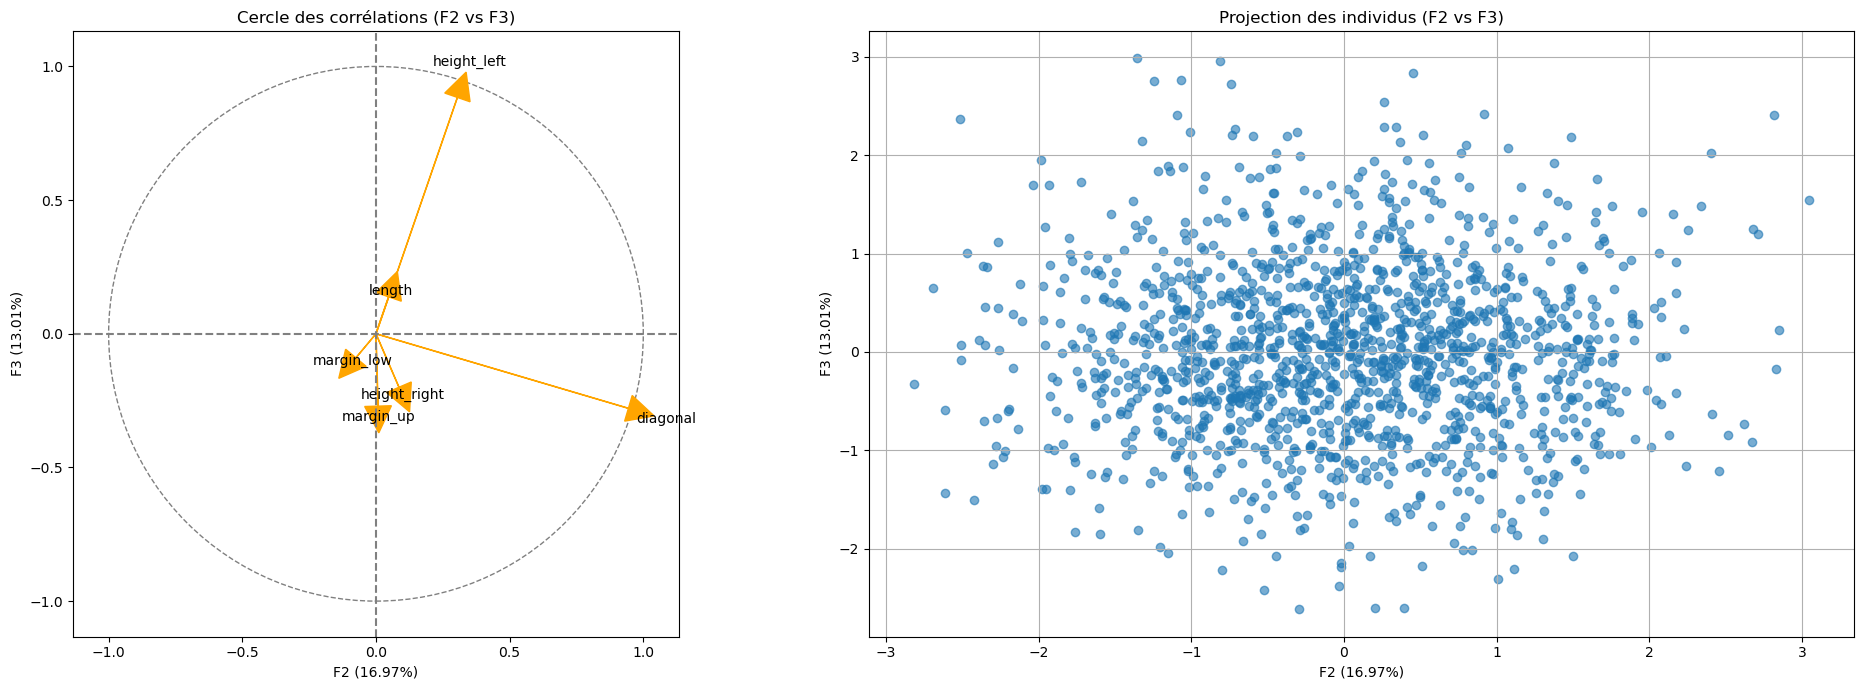

In [64]:
# Créer une figure et des axes pour les sous-plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Correlation circle (Cercle des corrélations)
correlation_circle(pca_3d, features, ax=axes[0], dim1=1, dim2=2)  # F2 and F3
axes[0].set_title("Cercle des corrélations (F2 vs F3)")

# Factorial planes (Projection des individus)
factorial_planes(X_projection_3d, pca_3d, ax=axes[1], dim1=1, dim2=2)  # F2 and F3
axes[1].set_title("Projection des individus (F2 vs F3)")

plt.tight_layout()
plt.show()

#### K-Means - Méthode du coude

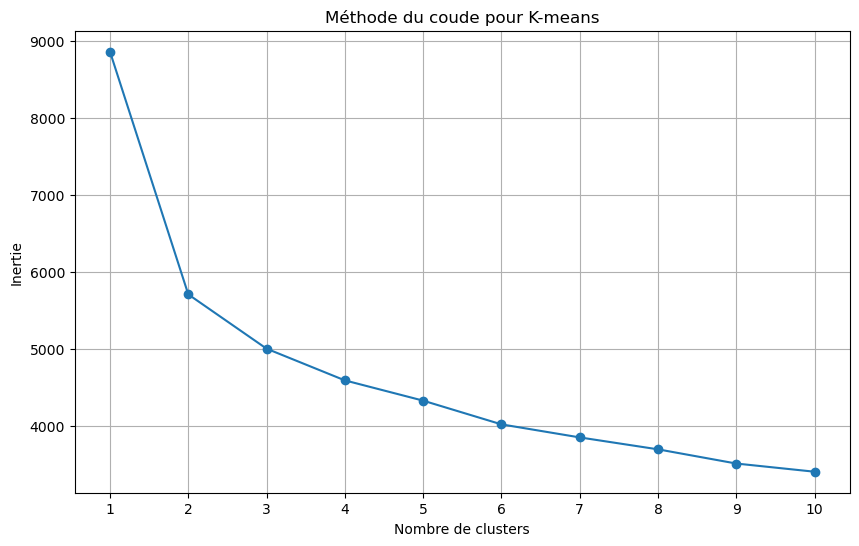

In [131]:
# Définir une liste pour stocker l'inertie
inertias = []

# Définir la plage de nombres de clusters à tester
range_n_clusters = range(1, 11)  # Tester de 1 à 10 clusters

# Appliquer K-means pour chaque nombre de clusters et calculer l'inertie
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=46)
    kmeans.fit(X_scaled)  # X_scaled est la matrice de données normalisées
    inertias.append(kmeans.inertia_)

# Tracer la courbe de la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertias, marker='o')
plt.title("Méthode du coude pour K-means")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.xticks(range_n_clusters)  # Afficher les ticks sur l'axe x
plt.grid()
plt.show()

#### K-Means - Visualisation des clusters en 2D

   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   
5        True    172.17       103.74        104.08        4.42       2.95   

   length  Cluster  
1  113.09        1  
2  113.16        1  
3  113.51        1  
4  112.54        1  
5  112.81        1  


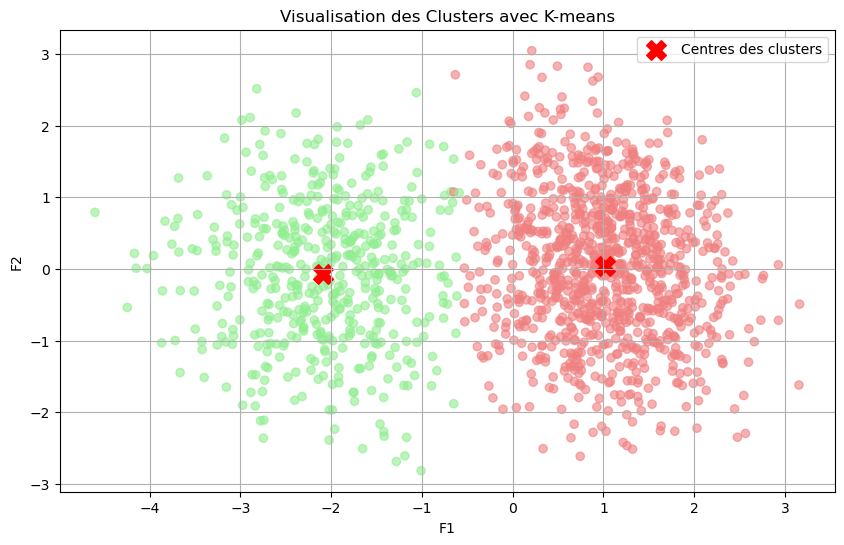

In [66]:
# Initialiser le modèle K-means avec 2 clusters
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=46)

# Ajuster le modèle aux données
kmeans.fit(X_projection_3d)

# Récupérer les labels de cluster
labels = kmeans.labels_

# Ajouter les labels de cluster aux données d'origine
data_with_clusters = data_without_outliers.copy()  # 
data_with_clusters['Cluster'] = labels  # Ajouter les labels de cluster

# Affichage des 5 premières lignes des données avec les clusters
print(data_with_clusters.head())

# Visualiser les clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_projection_3d[:, 0], X_projection_3d[:, 1], c=labels, cmap=custom_cmap, alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='red', marker='X', label='Centres des clusters')
plt.title('Visualisation des Clusters avec K-means')
plt.xlabel(composantes_no_3d[0])  # Nom de la première caractéristique
plt.ylabel(composantes_no_3d[1])  # Nom de la deuxième caractéristique
plt.legend()
plt.grid()
plt.show()

#### K-Means - Visualisation des clusters en 3D interactif

In [67]:
import plotly.express as px

# Visualisation interactive avec Plotly
fig = px.scatter_3d(x=X_projection_3d[:, 0], y=X_projection_3d[:, 1], z=X_projection_3d[:, 2],
                    color=labels, title='Clusters avec K-means (3D PCA)',
                    labels={'x': 'F1',
                            'y': 'F2',
                            'z': 'F3'},
                   color_continuous_scale=['lightgreen', 'lightcoral'], # Palette de couleurs pour les clusters)
                   opacity=0.5)  # Ajouter de la transparence aux points des clusters

# Ajuster la taille de la figure (largeur et hauteur)
fig.update_layout(
    autosize=True, # Largeur de la figure width=800 ou autosize=True par exemple
    height=800,  # Hauteur de la figure, ici ajustée pour un rendu moins "plat"
)

# Ajouter les centres des clusters
fig.add_scatter3d(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], z=kmeans.cluster_centers_[:, 2],
                  mode='markers', marker=dict(size=10, color='black', symbol='x'), name="Centroids")

# Modifier la position de la légende
fig.update_layout(
    legend=dict(
        x=0.95,  # Position horizontal (0 à 1)
        y=1,  # Position vertical (0 à 1)
        title=None  # Supprimer le titre de la légende si nécessaire
    )
)
fig.show()

<img src="img/clusters_3d.jpg" style="display: block; margin-left: auto; margin-right: auto; width: 100%;"/>

#### Analyse des résultats obtenus avec K-means

In [68]:
data_with_clusters.head(2)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   

   length  Cluster  
1  113.09        1  
2  113.16        1

In [69]:
data_with_clusters['is_genuine'].value_counts()

is_genuine
True     993
False    483
Name: count, dtype: int64

##### Matrice de confusion

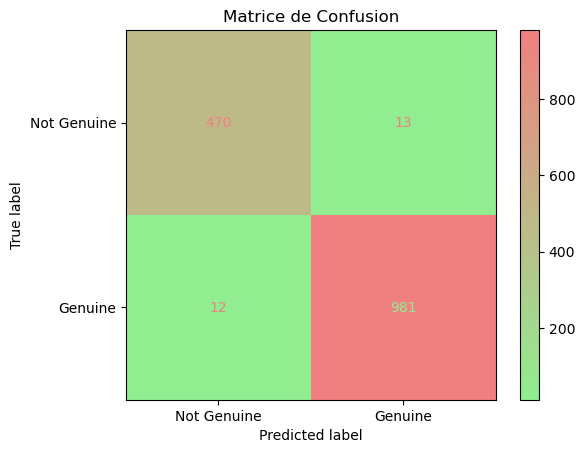

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Convertir les valeurs booléennes en entiers pour la matrice de confusion
data_with_clusters['is_genuine'] = data_with_clusters['is_genuine'].astype(int)

# Créer la matrice de confusion
cm = confusion_matrix(data_with_clusters['is_genuine'], data_with_clusters['Cluster'])

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Not Genuine", "Genuine"])
disp.plot(cmap=custom_lin_cmap)
plt.title("Matrice de Confusion")
plt.show()

In [71]:
# Extraire les valeurs TN, FP, FN, TP
TN, FP, FN, TP = cm.ravel()

# Calculer les statistiques
accuracy = (TP + TN) / (TP + TN + FP + FN)  # Taux de précision
sensitivity = TP / (TP + FN)  # Sensibilité (ou rappel)
specificity = TN / (TN + FP)  # Spécificité
precision = TP / (TP + FP)  # Précision
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)  # F1-score

# Afficher les résultats avec définitions
print("Statistiques de performance du modèle :\n")
print(f"1. Accuracy (Taux de précision) : {accuracy:.4f} \n   Définition : Proportion de prédictions correctes (vrais positifs et vrais négatifs) par rapport au total des prédictions.\n")
print(f"2. Sensitivity (Rappel) : {sensitivity:.4f} \n   Définition : Proportion des vrais positifs parmi tous les cas positifs.\n")
print(f"3. Specificity : {specificity:.4f} \n   Définition : Proportion des vrais négatifs parmi tous les cas négatifs.\n")
print(f"4. Precision : {precision:.4f} \n   Définition : Proportion des vrais positifs parmi toutes les prédictions positives.\n")
print(f"5. F1 Score : {f1_score:.4f} \n   Définition : Moyenne harmonique de la précision et de la sensibilité.\n")

Statistiques de performance du modèle :

1. Accuracy (Taux de précision) : 0.9831 
   Définition : Proportion de prédictions correctes (vrais positifs et vrais négatifs) par rapport au total des prédictions.

2. Sensitivity (Rappel) : 0.9879 
   Définition : Proportion des vrais positifs parmi tous les cas positifs.

3. Specificity : 0.9731 
   Définition : Proportion des vrais négatifs parmi tous les cas négatifs.

4. Precision : 0.9869 
   Définition : Proportion des vrais positifs parmi toutes les prédictions positives.

5. F1 Score : 0.9874 
   Définition : Moyenne harmonique de la précision et de la sensibilité.



Nous pouvons observer la distribution de chaque variable en fonction du cluster dans lequel l'individu a été classifié

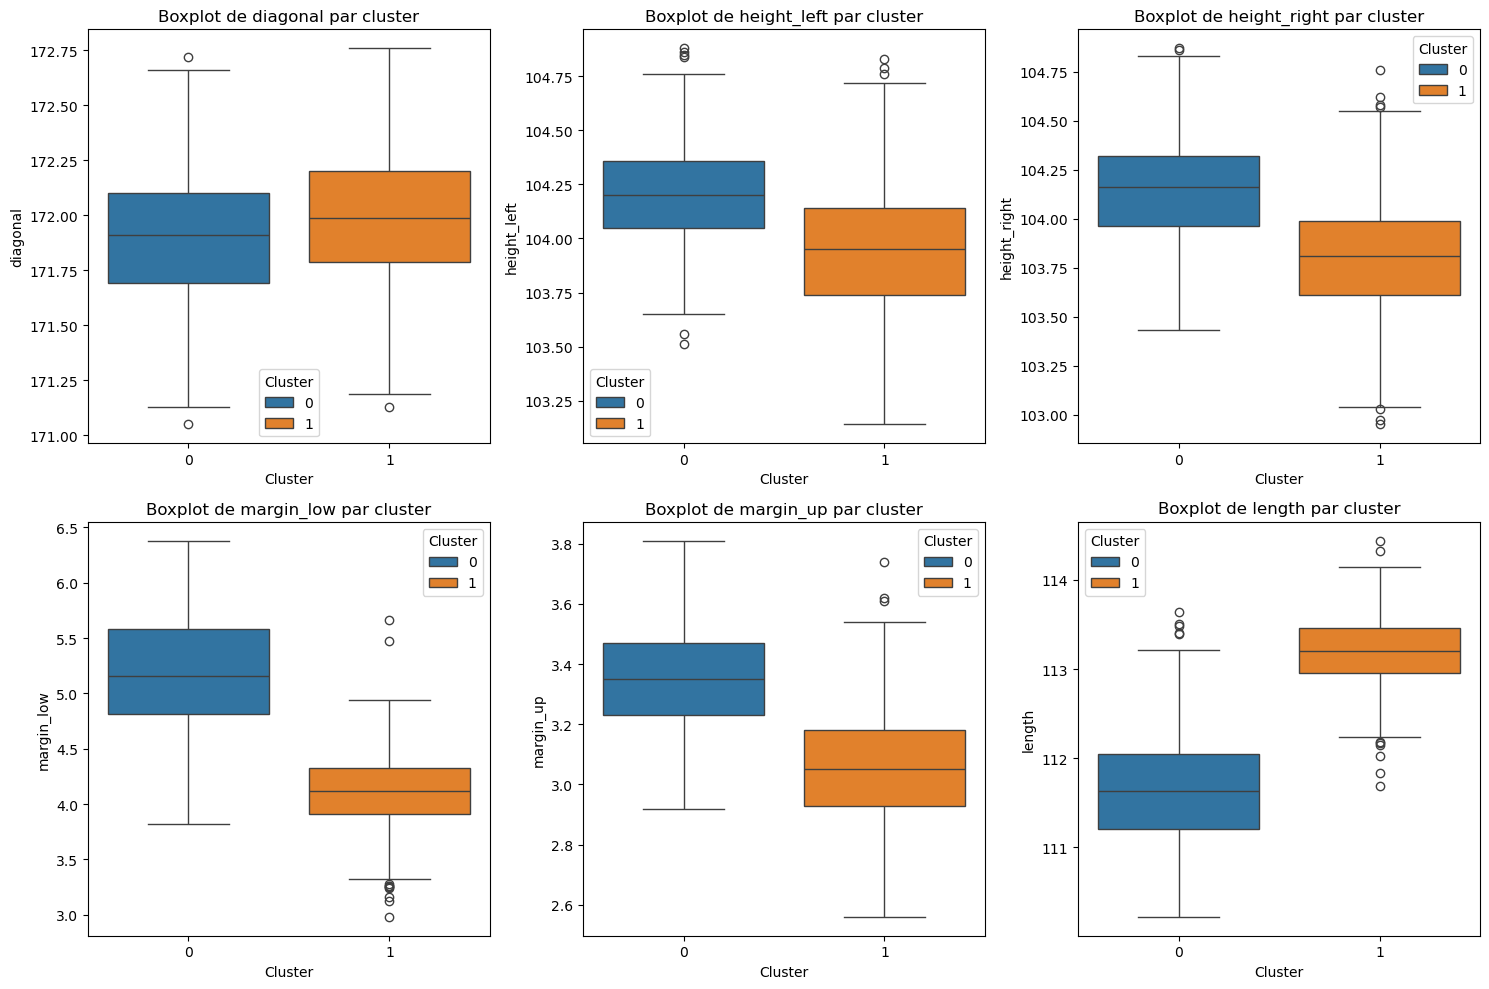

In [72]:
features = [col for col in data_with_clusters.columns if col not in ['is_genuine', 'Cluster']]
plt.figure(figsize=(15, 10))
for i, feat in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=data_with_clusters, x='Cluster', y=feat, hue='Cluster')
    plt.title(f"Boxplot de {feat} par cluster")

plt.tight_layout()
plt.show()

## Méthodes supervisées : Régression Logistique / Random Forest / Réseau neuronal

## 1 - Régréssion logistique

#### Méthodologie pour chaque modèle
- Ajustement du modèle sur les données d'entrainement  
- Validation croisée K-fold  
- Analyse des Odds-Ratio  
- Test du modèle / Matrice de confusion  
- Calcul des métriques de performances / Calcul de l'AUC et visualisation de la courbe ROC  
- Analyse de performance
 

#### Séparation des datas

On commence par séparer le jeu de données   
un jeu de données d'entrainement que l'on nommera "_train"  
un jeu de données test que l'on nommera "_test"

In [73]:
from sklearn.model_selection import train_test_split

# Définir les variables indépendantes (X) et la variable dépendante (y)
X = data[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = data['is_genuine']

# Séparer les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

### A. Régression Logistique

On commence par importer les bibiothèques que nous utiliserons

In [74]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

#### Logistic Model

In [75]:
# Je définis une fonction de régression logistique que j'utiliserai pour d'autres modèles

def fit_logistic_model(X_train, y_train):
    X_train_with_const = sm.add_constant(X_train)  # Ajouter une constante
    logit_model = sm.Logit(y_train, X_train_with_const)  # Ajuster le modèle
    result = logit_model.fit()  # Apprendre les paramètres
    print(f"\nRésultats du modèle :\n{result.summary()}")
    return result


In [76]:
# j'utilise ma fonction sur les données d'entrainement avec X_train qui correspond à toutes les variables indépendantes.
result = fit_logistic_model(X_train, y_train)

Optimization terminated successfully.
         Current function value: 0.030027
         Iterations 13

Résultats du modèle :
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Thu, 10 Oct 2024   Pseudo R-squ.:                  0.9524
Time:                        14:32:34   Log-Likelihood:                -36.032
converged:                       True   LL-Null:                       -756.70
Covariance Type:            nonrobust   LLR p-value:                2.722e-308
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -85.5652    259.380     -0.330      0.741    -593.941     422.811

In [77]:
# Je définis une fonction K-Fold pour validation croisée

def cross_validate_logit(X_train, y_train, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=46)
    cv_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Ajouter une constante
        X_train_fold_with_const = sm.add_constant(X_train_fold)
        X_val_fold_with_const = sm.add_constant(X_val_fold)
        
        # Ajuster le modèle
        logit_model_fold = sm.Logit(y_train_fold, X_train_fold_with_const)
        result_fold = logit_model_fold.fit(disp=0)
        
        # Prédictions sur le pli de validation
        y_val_pred = result_fold.predict(X_val_fold_with_const)
        y_val_pred_class = (y_val_pred > 0.5).astype(int)
        
        # Calculer les métriques
        accuracy = np.mean(y_val_pred_class == y_val_fold)
        auc = roc_auc_score(y_val_fold, y_val_pred)
        cv_scores.append({'Accuracy': accuracy, 'AUC': auc})
    
    # Moyenne des scores
    mean_accuracy = np.mean([score['Accuracy'] for score in cv_scores])
    mean_auc = np.mean([score['AUC'] for score in cv_scores])
    
    print(f"\nMoyenne des Accuracy sur {n_splits} plis: {mean_accuracy:.4f}")
    print(f"Moyenne des AUC sur {n_splits} plis: {mean_auc:.4f}\n")
    
    return mean_accuracy, mean_auc


In [78]:
# j'appelle ma fonction de validation croisée avec les mêmes données d'entrainement

cross_validate_logit(X_train, y_train)


Moyenne des Accuracy sur 5 plis: 0.9908
Moyenne des AUC sur 5 plis: 0.9980



(0.9908333333333333, 0.9979964957421679)

In [79]:
# Je crée une fonction d'analyse simple des Odds-Ratios

def analyze_odds_ratios(result):
    coefficients = result.params
    odds_ratios = np.exp(coefficients)
    p_values = result.pvalues

    odds_ratios_df = pd.DataFrame({
        'Coefficient': coefficients,
        'Odds Ratio': odds_ratios,
        'p-value': p_values
    })

    analysis = []
    analysis.append("\nAnalyse des Odds Ratios :")
    for feature, row in odds_ratios_df.iterrows():
        coeff = row['Coefficient']
        odds_ratio = row['Odds Ratio']
        p_value = row['p-value']
        
        if odds_ratio < 1:
            interpretation = f"L'augmentation de {feature} est associée à une réduction des cotes (Odds) de {1 - odds_ratio:.2%}."
        else:
            interpretation = f"L'augmentation de {feature} est associée à une augmentation des cotes (Odds) de {odds_ratio - 1:.2%}."

        sig = "(significatif)" if p_value < 0.05 else "(non significatif)"
        analysis.append(f"- **{feature}**: Coefficient = {coeff:.4f}, Odds Ratio = {odds_ratio:.4f}. {interpretation}")
    
    return '\n'.join(analysis)


In [80]:
# J'appelle ma fonction d'Analyse des Odds Ratios

odds_analysis = analyze_odds_ratios(result)
print(odds_analysis)


Analyse des Odds Ratios :
- **const**: Coefficient = -85.5652, Odds Ratio = 0.0000. L'augmentation de const est associée à une réduction des cotes (Odds) de 100.00%.
- **diagonal**: Coefficient = -0.3910, Odds Ratio = 0.6764. L'augmentation de diagonal est associée à une réduction des cotes (Odds) de 32.36%.
- **height_left**: Coefficient = -1.8284, Odds Ratio = 0.1607. L'augmentation de height_left est associée à une réduction des cotes (Odds) de 83.93%.
- **height_right**: Coefficient = -2.3205, Odds Ratio = 0.0982. L'augmentation de height_right est associée à une réduction des cotes (Odds) de 90.18%.
- **margin_low**: Coefficient = -5.4226, Odds Ratio = 0.0044. L'augmentation de margin_low est associée à une réduction des cotes (Odds) de 99.56%.
- **margin_up**: Coefficient = -8.8495, Odds Ratio = 0.0001. L'augmentation de margin_up est associée à une réduction des cotes (Odds) de 99.99%.
- **length**: Coefficient = 5.6669, Odds Ratio = 289.1358. L'augmentation de length est assoc

In [81]:
# Je crée une fonction d'évaluation des métriques de performance

def evaluate_model(y_test, y_pred_class, y_pred_prob, model_name):
    cm = confusion_matrix(y_test, y_pred_class)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy = (TP + TN) / len(y_test)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0
    auc_score = roc_auc_score(y_test, y_pred_prob)

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1 Score': f1_score,
        'AUC Score': auc_score
    }

    return metrics


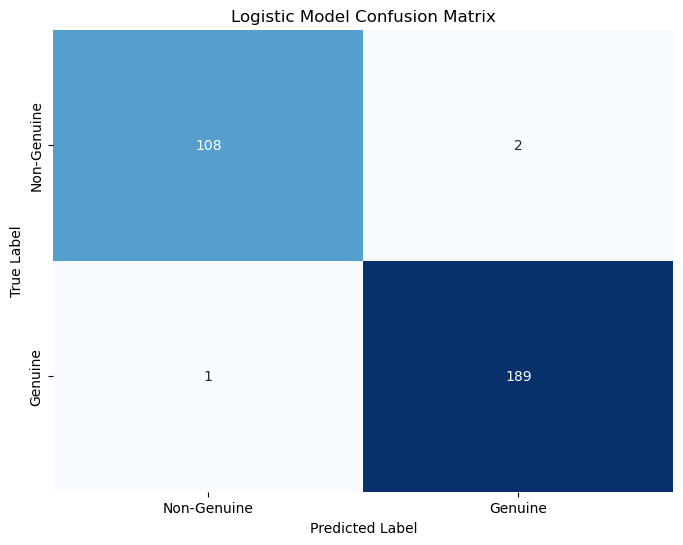

In [82]:
# Je nomme mon model puis j'appelle la fonction d'évaluation des métriques de performance
model_name='Logistic Model'

#  Je réalise des prédictions sur l'ensemble de test
X_test_with_const = sm.add_constant(X_test)
y_pred_prob = result.predict(X_test_with_const)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Créer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_class)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Genuine", "Genuine"],
            yticklabels=["Non-Genuine", "Genuine"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"{model_name} Confusion Matrix")
plt.show()

In [83]:
# Évaluation du modèle
metrics = evaluate_model(y_test, y_pred_class, y_pred_prob, model_name)

# Afficher les résultats avec formatage
print(f"\nStatistiques de performance du modèle {model_name} :\n")
for metric, value in metrics.items():
    # Formater uniquement les valeurs numériques
    if isinstance(value, (int, float)):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


Statistiques de performance du modèle Logistic Model :

Model: Logistic Model
Accuracy: 0.9900
Sensitivity: 0.9947
Specificity: 0.9818
Precision: 0.9895
F1 Score: 0.9921
AUC Score: 0.9999


In [84]:
# Fonction d'affichage de la courbe ROC et de calcul du score AUC

def plot_roc_curve(y_test, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = roc_auc_score(y_test, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()


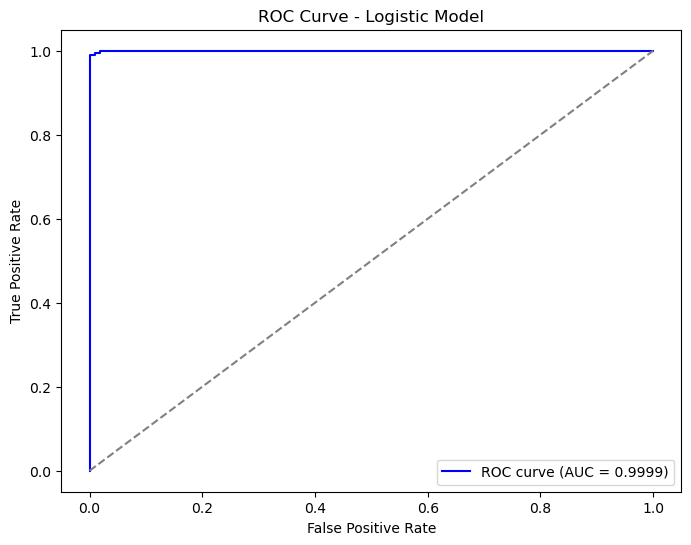

In [85]:
# Courbe ROC
plot_roc_curve(y_test, y_pred_prob, model_name)

In [86]:
# Initialisation d'un dataframe qui contiendra l'ensemble des métriques de mes modèles

metrics_table = pd.DataFrame(columns=['Model', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'AUC Score'])

In [87]:
# Je convertis le dictionnaire de métrique en dataframe pour l'ajouter à metrics_table

metrics_df = pd.DataFrame([metrics])
metrics_table = pd.concat([metrics_table, metrics_df], ignore_index=True)
metrics_table

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_19392\3680624223.py:4: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Model  Accuracy  Sensitivity  Specificity  Precision  F1 Score  \
0  Logistic Model      0.99     0.994737     0.981818   0.989529  0.992126   

   AUC Score  
0   0.999856

### B. Régression Logistique - Méthode Stepwise AIC

#### Logistic Model Step AIC

In [88]:
# Fonction pour calculer AIC
def calculate_aic(model):
    return model.aic
# Fonction pour effectuer la sélection stepwise
def stepwise_selection(X_train, y_train):
    initial_features = X_train.columns.tolist()
    best_aic = np.inf
    best_features = initial_features  # Conserver initialement toutes les features

    while True:
        changed = False
        current_features = best_features.copy()

        # Essayer de retirer une variable
        for feature in current_features:
            features_to_try = current_features.copy()
            features_to_try.remove(feature)

            model = sm.Logit(y_train, sm.add_constant(X_train[features_to_try])).fit(disp=0)
            aic = calculate_aic(model)

            if aic < best_aic:
                best_aic = aic
                best_features = features_to_try
                changed = True

        # Essayer d'ajouter une variable (après chaque suppression)
        for feature in X_train.columns:
            if feature not in best_features:
                features_to_try = best_features + [feature]

                model = sm.Logit(y_train, sm.add_constant(X_train[features_to_try])).fit(disp=0)
                aic = calculate_aic(model)

                if aic < best_aic:
                    best_aic = aic
                    best_features = features_to_try
                    changed = True

        # Si aucune variable n'a été changée, on arrête
        if not changed:
            break

    return best_features

# Appliquer la sélection stepwise
selected_features = stepwise_selection(X_train, y_train)

# Afficher les résultats
print("Variables sélectionnées :", selected_features)


Variables sélectionnées : ['height_left', 'height_right', 'margin_low', 'margin_up', 'length']


In [89]:
# j'utilise ma fonction sur les données d'entrainement avec X_train qui ne contient que les variables définies avec la méthode Step AIC
result = fit_logistic_model(X_train[selected_features], y_train)

Optimization terminated successfully.
         Current function value: 0.030075
         Iterations 12

Résultats du modèle :
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1194
Method:                           MLE   Df Model:                            5
Date:                Thu, 10 Oct 2024   Pseudo R-squ.:                  0.9523
Time:                        14:32:35   Log-Likelihood:                -36.090
converged:                       True   LL-Null:                       -756.70
Covariance Type:            nonrobust   LLR p-value:                1.614e-309
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -150.1900    175.992     -0.853      0.393    -495.127     194.747

In [90]:
# j'appelle ma fonction de validation croisée avec les mêmes données d'entrainement
cross_validate_logit(X_train[selected_features], y_train)


Moyenne des Accuracy sur 5 plis: 0.9917
Moyenne des AUC sur 5 plis: 0.9980



(0.9916666666666668, 0.9979623042741)

In [91]:
# J'appelle ma fonction d'Analyse des Odds Ratios
odds_analysis = analyze_odds_ratios(result)
print(odds_analysis)


Analyse des Odds Ratios :
- **const**: Coefficient = -150.1900, Odds Ratio = 0.0000. L'augmentation de const est associée à une réduction des cotes (Odds) de 100.00%.
- **height_left**: Coefficient = -1.8313, Odds Ratio = 0.1602. L'augmentation de height_left est associée à une réduction des cotes (Odds) de 83.98%.
- **height_right**: Coefficient = -2.2828, Odds Ratio = 0.1020. L'augmentation de height_right est associée à une réduction des cotes (Odds) de 89.80%.
- **margin_low**: Coefficient = -5.3097, Odds Ratio = 0.0049. L'augmentation de margin_low est associée à une réduction des cotes (Odds) de 99.51%.
- **margin_up**: Coefficient = -8.8069, Odds Ratio = 0.0001. L'augmentation de margin_up est associée à une réduction des cotes (Odds) de 99.99%.
- **length**: Coefficient = 5.6059, Odds Ratio = 272.0323. L'augmentation de length est associée à une augmentation des cotes (Odds) de 27103.23%.


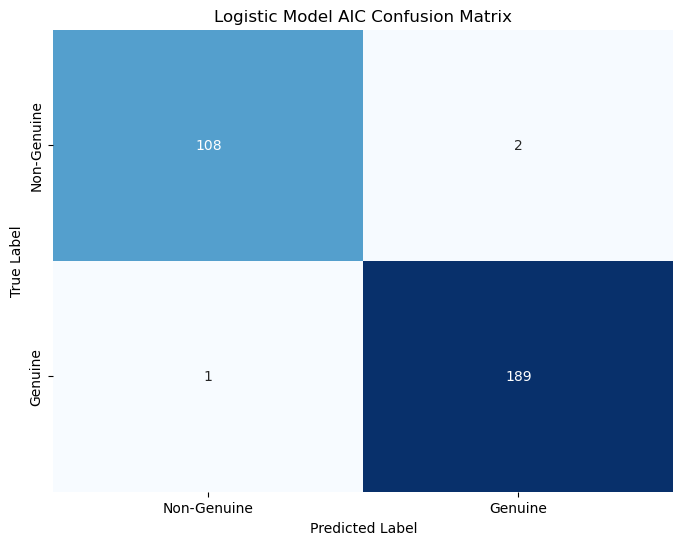

In [92]:
# Je nomme mon model puis j'appelle la fonction d'évaluation des métriques de performance
model_name='Logistic Model AIC'

#  Je réalise des prédictions sur l'ensemble de test [selected_features]
X_test_with_const = sm.add_constant(X_test[selected_features])
y_pred_prob = result.predict(X_test_with_const)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Créer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_class)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Genuine", "Genuine"],
            yticklabels=["Non-Genuine", "Genuine"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"{model_name} Confusion Matrix")
plt.show()

In [93]:
# Évaluation du modèle
metrics = evaluate_model(y_test, y_pred_class, y_pred_prob, model_name)

# Afficher les résultats avec formatage
print(f"\nStatistiques de performance du modèle {model_name} :\n")
for metric, value in metrics.items():
    # Formater uniquement les valeurs numériques
    if isinstance(value, (int, float)):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


Statistiques de performance du modèle Logistic Model AIC :

Model: Logistic Model AIC
Accuracy: 0.9900
Sensitivity: 0.9947
Specificity: 0.9818
Precision: 0.9895
F1 Score: 0.9921
AUC Score: 0.9999


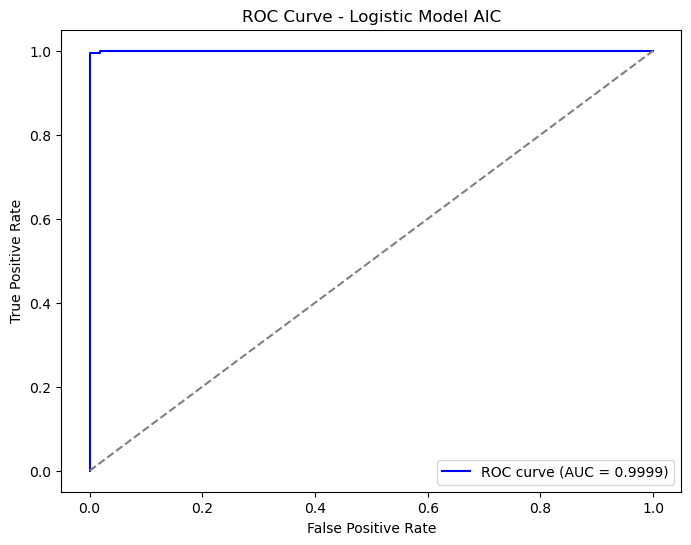

In [94]:
# Courbe ROC
plot_roc_curve(y_test, y_pred_prob, model_name)

In [95]:
# Je convertis le dictionnaire de métrique en dataframe pour l'ajouter à metrics_table
metrics_df = pd.DataFrame([metrics])
metrics_table = pd.concat([metrics_table, metrics_df], ignore_index=True)
metrics_table

Model  Accuracy  Sensitivity  Specificity  Precision  \
0      Logistic Model      0.99     0.994737     0.981818   0.989529   
1  Logistic Model AIC      0.99     0.994737     0.981818   0.989529   

   F1 Score  AUC Score  
0  0.992126   0.999856  
1  0.992126   0.999904

### C. Régression Logistique - Méthode Stepwise AIC Optimisé pour la spécificité

Nous allons paramétré nos seuils de prédictions afin d'optimiser la spécificité et réduire le risque de faux positif.  
Notre objectif est d'avoir un modèle performant dans sa globalité tout en détectant le maximum de faux billets.

#### Logistic Model Step AIC Opti

In [96]:
# Je crée une fonction pour calculer la spécificité
def calculate_specificity(pred_probs, actual_classes, threshold):
    predicted_classes = (pred_probs > threshold).astype(int)
    confusion = confusion_matrix(actual_classes, predicted_classes)
    
    if confusion.shape[0] == 2 and confusion.shape[1] == 2:
        TN = confusion[0, 0]  # Vrais négatifs
        FP = confusion[0, 1]  # Faux positifs
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    else:
        specificity = 0
    
    return specificity

In [97]:
# On teste plusieurs seuils de probabilité pour le modèle
thresholds = np.arange(0.5, 1.0, 0.01)
specificities = [calculate_specificity(y_pred_prob, y_test, t) for t in thresholds]

# Identifier le meilleur seuil
best_threshold = thresholds[np.argmax(specificities)]
best_specificity = max(specificities)

# Affichage des résultats
print(f"Meilleur seuil): {best_threshold:.2f}")
print(f"Spécificité à ce seuil: {best_specificity:.4f}")

Meilleur seuil): 0.66
Spécificité à ce seuil: 1.0000


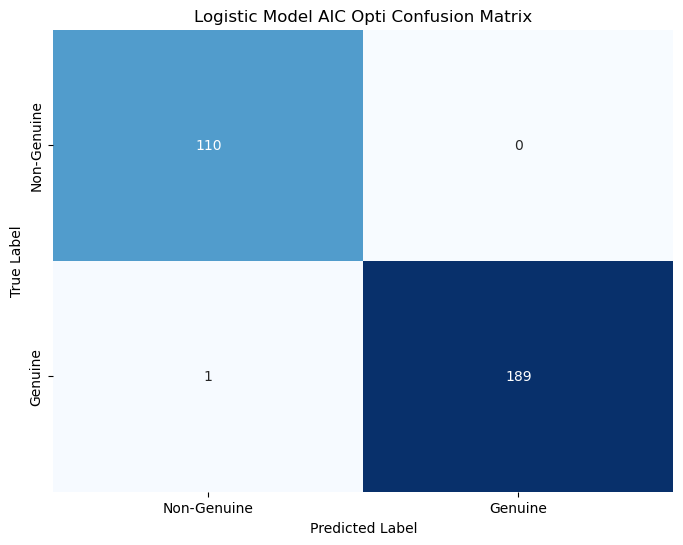

In [98]:
# Je nomme mon model puis j'appelle la fonction d'évaluation des métriques de performance
model_name='Logistic Model AIC Opti'

#  Je réalise des prédictions sur l'ensemble de test [selected_features]
X_test_with_const = sm.add_constant(X_test[selected_features])
y_pred_prob = result.predict(X_test_with_const)
y_pred_class = (y_pred_prob > best_threshold).astype(int)

# Créer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_class)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Genuine", "Genuine"],
            yticklabels=["Non-Genuine", "Genuine"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"{model_name} Confusion Matrix")
plt.show()

In [99]:
# Évaluation du modèle
metrics = evaluate_model(y_test, y_pred_class, y_pred_prob, model_name)

# Afficher les résultats avec formatage
print(f"\nStatistiques de performance du modèle {model_name} :\n")
for metric, value in metrics.items():
    # Formater uniquement les valeurs numériques
    if isinstance(value, (int, float)):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


Statistiques de performance du modèle Logistic Model AIC Opti :

Model: Logistic Model AIC Opti
Accuracy: 0.9967
Sensitivity: 0.9947
Specificity: 1.0000
Precision: 1.0000
F1 Score: 0.9974
AUC Score: 0.9999


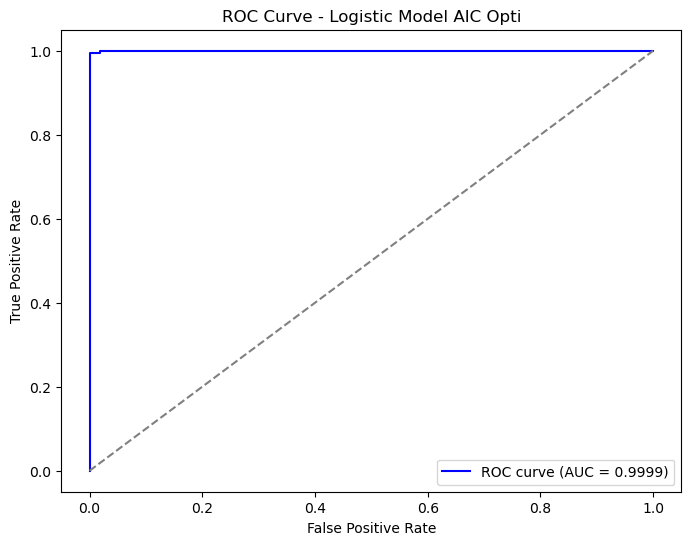

In [100]:
# Courbe ROC
plot_roc_curve(y_test, y_pred_prob, model_name)

In [101]:
# Je convertis le dictionnaire de métrique en dataframe pour l'ajouter à metrics_table
metrics_df = pd.DataFrame([metrics])
metrics_table = pd.concat([metrics_table, metrics_df], ignore_index=True)
metrics_table

Model  Accuracy  Sensitivity  Specificity  Precision  \
0           Logistic Model  0.990000     0.994737     0.981818   0.989529   
1       Logistic Model AIC  0.990000     0.994737     0.981818   0.989529   
2  Logistic Model AIC Opti  0.996667     0.994737     1.000000   1.000000   

   F1 Score  AUC Score  
0  0.992126   0.999856  
1  0.992126   0.999904  
2  0.997361   0.999904

## 2 - Random Forest

### A. Random Foret

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

In [103]:
def fit_random_forest(X_train, y_train, n_estimators=100, random_state=46):
    # Initialiser le classificateur Random Forest
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    
    # Entraîner le modèle
    rf_classifier.fit(X_train, y_train)
    
    # Importance des caractéristiques
    feature_importances = rf_classifier.feature_importances_
    
    # Afficher l'importance des caractéristiques
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nImportance des caractéristiques :\n", importance_df)
    
    return rf_classifier, importance_df


Importance des caractéristiques :
         Feature  Importance
5        length    0.484537
3    margin_low    0.307518
4     margin_up    0.110211
2  height_right    0.050227
1   height_left    0.039194
0      diagonal    0.008312


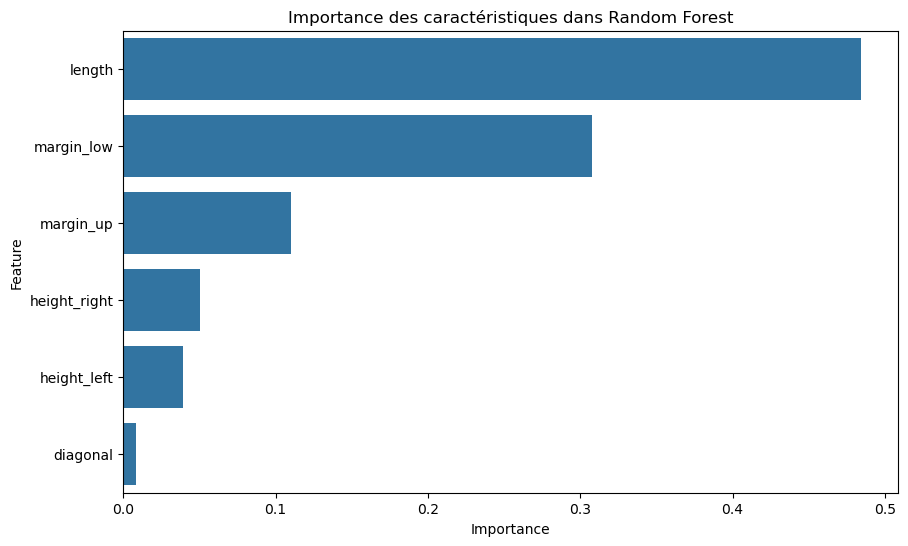

In [104]:
# Entraîner le modèle Random Forest
rf_model, importance_df = fit_random_forest(X_train, y_train)

# Afficher l'importance des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Importance des caractéristiques dans Random Forest')
plt.show()

In [105]:
def cross_validate_random_forest(X_train, y_train, n_splits=5, n_estimators=100, random_state=46):
    # Initialiser le classificateur Random Forest
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    
    # K-Fold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_scores = []
    
    # Boucle sur chaque pli de validation
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Entraîner le modèle sur le pli d'entraînement
        rf_classifier.fit(X_train_fold, y_train_fold)
        
        # Prédictions sur le pli de validation
        y_val_pred_class = rf_classifier.predict(X_val_fold)
        y_val_pred_prob = rf_classifier.predict_proba(X_val_fold)[:, 1]  # Probabilité de la classe positive
        
        # Calculer les métriques
        accuracy = accuracy_score(y_val_fold, y_val_pred_class)
        auc = roc_auc_score(y_val_fold, y_val_pred_prob)
        cv_scores.append({'Accuracy': accuracy, 'AUC': auc})
    
    # Moyenne des scores
    mean_accuracy = np.mean([score['Accuracy'] for score in cv_scores])
    mean_auc = np.mean([score['AUC'] for score in cv_scores])
    
    print(f"\nMoyenne des Accuracy sur {n_splits} plis: {mean_accuracy:.4f}")
    print(f"Moyenne des AUC sur {n_splits} plis: {mean_auc:.4f}\n")
    
    return mean_accuracy, mean_auc

In [106]:
# Effectuer la validation croisée sur 5 plis
mean_accuracy, mean_auc = cross_validate_random_forest(X_train, y_train, n_splits=5)

# Afficher les résultats
print(f"Moyenne de l'accuracy: {mean_accuracy:.4f}")
print(f"Moyenne de l'AUC: {mean_auc:.4f}")


Moyenne des Accuracy sur 5 plis: 0.9917
Moyenne des AUC sur 5 plis: 0.9993

Moyenne de l'accuracy: 0.9917
Moyenne de l'AUC: 0.9993


In [107]:
def evaluate_model_rf(y_test, y_pred_class, y_pred_prob, model_name):
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_test, y_pred_class)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Calculer les différentes métriques
    accuracy = (TP + TN) / len(y_test)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0
    auc_score = roc_auc_score(y_test, y_pred_prob)

    # Rassembler les métriques dans un dictionnaire
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1 Score': f1_score,
        'AUC Score': auc_score
    }

    return metrics

In [108]:
# Prédictions sur l'ensemble de test
y_pred_class = rf_model.predict(X_test)  # Prédictions des classes
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # Prédictions des probabilités (classes positives)

# Évaluation du modèle
model_name = 'Random Forest Classifier'
metrics = evaluate_model_rf(y_test, y_pred_class, y_pred_prob, model_name)

# Afficher les résultats avec formatage
print(f"\nStatistiques de performance du modèle {model_name} :\n")
for metric, value in metrics.items():
    # Formater uniquement les valeurs numériques
    if isinstance(value, (int, float)):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


Statistiques de performance du modèle Random Forest Classifier :

Model: Random Forest Classifier
Accuracy: 0.9900
Sensitivity: 1.0000
Specificity: 0.9727
Precision: 0.9845
F1 Score: 0.9922
AUC Score: 0.9998


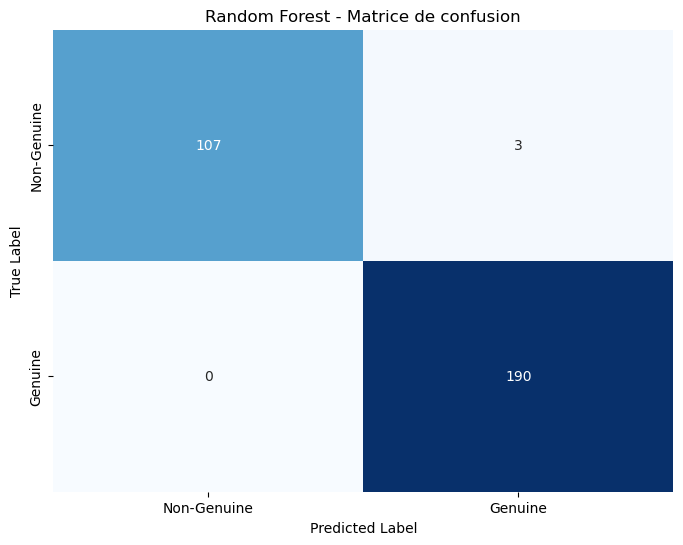

In [109]:
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Genuine", "Genuine"],
            yticklabels=["Non-Genuine", "Genuine"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"Random Forest - Matrice de confusion")
plt.show()

In [110]:
def plot_roc_curve_rf(y_test, y_pred_prob, model_name):
    # Calculer les courbes ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = roc_auc_score(y_test, y_pred_prob)

    # Tracer la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()


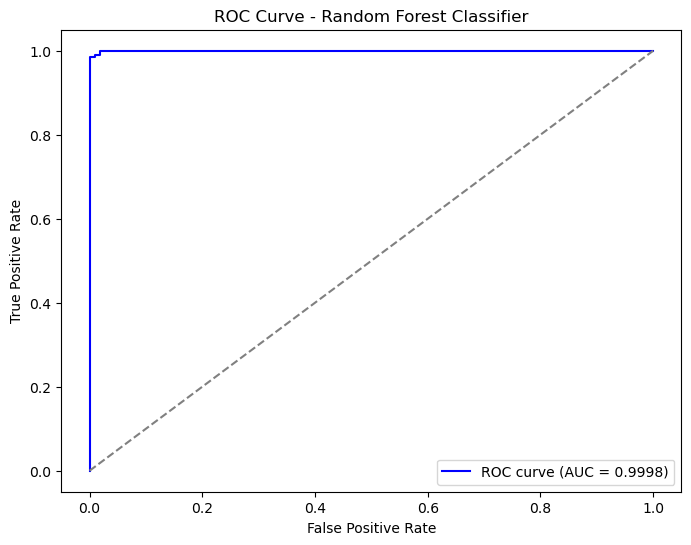

In [111]:
# Étape 3 : Tracer la courbe ROC et afficher le score AUC
model_name = 'Random Forest Classifier'
plot_roc_curve_rf(y_test, y_pred_prob, model_name)


In [112]:
# Je convertis le dictionnaire de métrique en dataframe pour l'ajouter à metrics_table
metrics_df = pd.DataFrame([metrics])
metrics_table = pd.concat([metrics_table, metrics_df], ignore_index=True)
metrics_table

Model  Accuracy  Sensitivity  Specificity  Precision  \
0            Logistic Model  0.990000     0.994737     0.981818   0.989529   
1        Logistic Model AIC  0.990000     0.994737     0.981818   0.989529   
2   Logistic Model AIC Opti  0.996667     0.994737     1.000000   1.000000   
3  Random Forest Classifier  0.990000     1.000000     0.972727   0.984456   

   F1 Score  AUC Score  
0  0.992126   0.999856  
1  0.992126   0.999904  
2  0.997361   0.999904  
3  0.992167   0.999761

### B. Random Forest AIC

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

In [114]:
def fit_random_forest(X_train, y_train, n_estimators=100, random_state=46):
    # Initialiser le classificateur Random Forest
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    
    # Entraîner le modèle
    rf_classifier.fit(X_train, y_train)
    
    # Importance des caractéristiques
    feature_importances = rf_classifier.feature_importances_
    
    # Afficher l'importance des caractéristiques
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nImportance des caractéristiques :\n", importance_df)
    
    return rf_classifier, importance_df


Importance des caractéristiques :
         Feature  Importance
4        length    0.529150
2    margin_low    0.311811
3     margin_up    0.107363
1  height_right    0.035210
0   height_left    0.016467


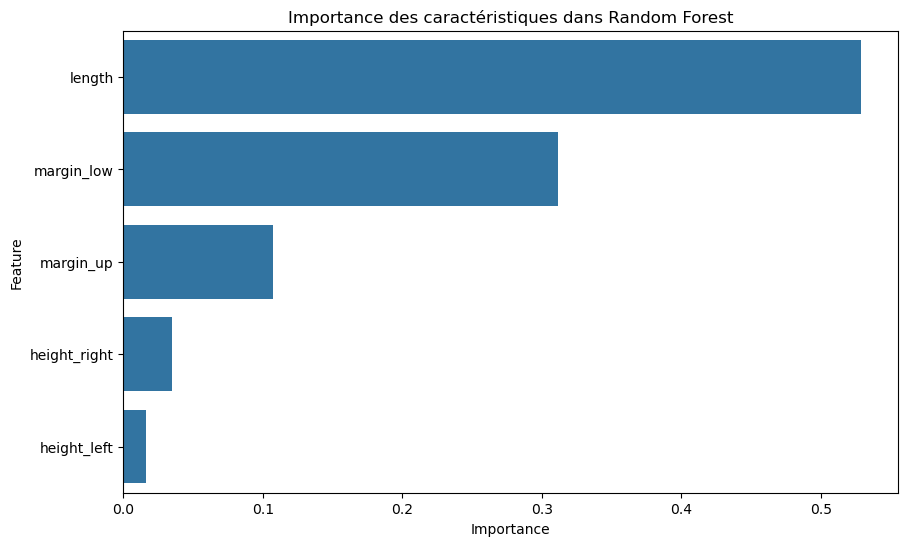

In [115]:
# Entraîner le modèle Random Forest
rf_model, importance_df = fit_random_forest(X_train[selected_features], y_train)

# Afficher l'importance des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Importance des caractéristiques dans Random Forest')
plt.show()

In [116]:
def cross_validate_random_forest(X_train, y_train, n_splits=5, n_estimators=100, random_state=46):
    # Initialiser le classificateur Random Forest
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    
    # K-Fold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_scores = []
    
    # Boucle sur chaque pli de validation
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Entraîner le modèle sur le pli d'entraînement
        rf_classifier.fit(X_train_fold, y_train_fold)
        
        # Prédictions sur le pli de validation
        y_val_pred_class = rf_classifier.predict(X_val_fold)
        y_val_pred_prob = rf_classifier.predict_proba(X_val_fold)[:, 1]  # Probabilité de la classe positive
        
        # Calculer les métriques
        accuracy = accuracy_score(y_val_fold, y_val_pred_class)
        auc = roc_auc_score(y_val_fold, y_val_pred_prob)
        cv_scores.append({'Accuracy': accuracy, 'AUC': auc})
    
    # Moyenne des scores
    mean_accuracy = np.mean([score['Accuracy'] for score in cv_scores])
    mean_auc = np.mean([score['AUC'] for score in cv_scores])
    
    print(f"\nMoyenne des Accuracy sur {n_splits} plis: {mean_accuracy:.4f}")
    print(f"Moyenne des AUC sur {n_splits} plis: {mean_auc:.4f}\n")
    
    return mean_accuracy, mean_auc

In [117]:
# Effectuer la validation croisée sur 5 plis
mean_accuracy, mean_auc = cross_validate_random_forest(X_train[selected_features], y_train, n_splits=5)

# Afficher les résultats
print(f"Moyenne de l'accuracy: {mean_accuracy:.4f}")
print(f"Moyenne de l'AUC: {mean_auc:.4f}")


Moyenne des Accuracy sur 5 plis: 0.9917
Moyenne des AUC sur 5 plis: 0.9991

Moyenne de l'accuracy: 0.9917
Moyenne de l'AUC: 0.9991


In [118]:
def evaluate_model_rf(y_test, y_pred_class, y_pred_prob, model_name):
    # Calculer la matrice de confusion
    cm = confusion_matrix(y_test, y_pred_class)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Calculer les différentes métriques
    accuracy = (TP + TN) / len(y_test)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0
    auc_score = roc_auc_score(y_test, y_pred_prob)

    # Rassembler les métriques dans un dictionnaire
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1 Score': f1_score,
        'AUC Score': auc_score
    }

    return metrics

In [119]:
# Prédictions sur l'ensemble de test
y_pred_class = rf_model.predict(X_test[selected_features])  # Prédictions des classes
y_pred_prob = rf_model.predict_proba(X_test[selected_features])[:, 1]  # Prédictions des probabilités (classes positives)

# Évaluation du modèle
model_name = 'Random Forest AIC'
metrics = evaluate_model_rf(y_test, y_pred_class, y_pred_prob, model_name)

# Afficher les résultats avec formatage
print(f"\nStatistiques de performance du modèle {model_name} :\n")
for metric, value in metrics.items():
    # Formater uniquement les valeurs numériques
    if isinstance(value, (int, float)):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


Statistiques de performance du modèle Random Forest AIC :

Model: Random Forest AIC
Accuracy: 0.9933
Sensitivity: 1.0000
Specificity: 0.9818
Precision: 0.9896
F1 Score: 0.9948
AUC Score: 0.9997


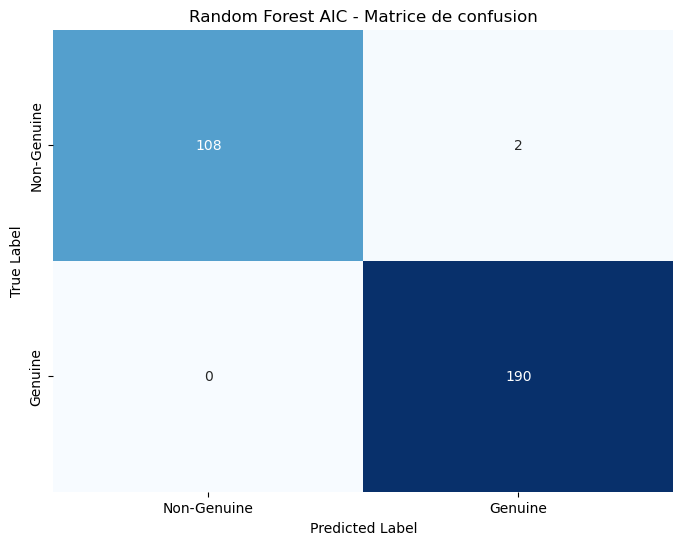

In [120]:
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Genuine", "Genuine"],
            yticklabels=["Non-Genuine", "Genuine"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"Random Forest AIC - Matrice de confusion")
plt.show()

In [121]:
def plot_roc_curve_rf(y_test, y_pred_prob, model_name):
    # Calculer les courbes ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_score = roc_auc_score(y_test, y_pred_prob)

    # Tracer la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f"ROC curve (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()


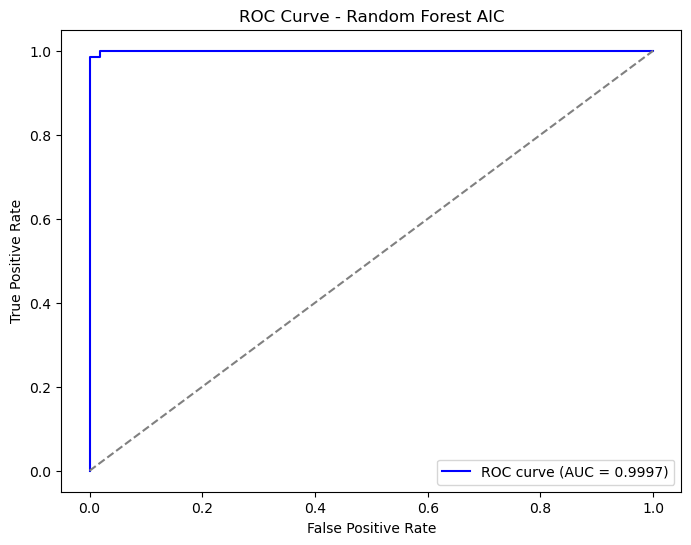

In [122]:
# Étape 3 : Tracer la courbe ROC et afficher le score AUC
model_name = 'Random Forest AIC'
plot_roc_curve_rf(y_test, y_pred_prob, model_name)


In [123]:
# Je convertis le dictionnaire de métrique en dataframe pour l'ajouter à metrics_table
metrics_df = pd.DataFrame([metrics])
metrics_table = pd.concat([metrics_table, metrics_df], ignore_index=True)
metrics_table

Model  Accuracy  Sensitivity  Specificity  Precision  \
0            Logistic Model  0.990000     0.994737     0.981818   0.989529   
1        Logistic Model AIC  0.990000     0.994737     0.981818   0.989529   
2   Logistic Model AIC Opti  0.996667     0.994737     1.000000   1.000000   
3  Random Forest Classifier  0.990000     1.000000     0.972727   0.984456   
4         Random Forest AIC  0.993333     1.000000     0.981818   0.989583   

   F1 Score  AUC Score  
0  0.992126   0.999856  
1  0.992126   0.999904  
2  0.997361   0.999904  
3  0.992167   0.999761  
4  0.994764   0.999713

## 3 - Réseau neuronal

Je commence par importer la bibliothèque TensorFlow pour créer et entraîner des modèles de deep learning, tels que des réseaux de neurones, afin de résoudre des problèmes de classification ou de régression, et pour tirer parti des capacités avancées de calcul sur GPU ou CPU.

In [124]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.10.0


In [ ]:
np.random.seed(46)
tf.random.set_seed(46)

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

10/10 [==============================] - 0s 875us/step
                      Model  Accuracy  Sensitivity  Specificity  Precision  \
0            Logistic Model  0.990000     0.994737     0.981818   0.989529   
1        Logistic Model AIC  0.990000     0.994737     0.981818   0.989529   
2   Logistic Model AIC Opti  0.996667     0.994737     1.000000   1.000000   
3  Random Forest Classifier  0.990000     1.000000     0.972727   0.984456   
4         Random Forest AIC  0.993333     1.000000     0.981818   0.989583   
5      Neural Network Model  0.980000     1.000000     0.945455   0.969388   

   F1 Score  AUC Score  
0  0.992126   0.999856  
1  0.992126   0.999904  
2  0.997361   0.999904  
3  0.992167   0.999761  
4  0.994764   0.999713  
5  0.984456   0.999426  


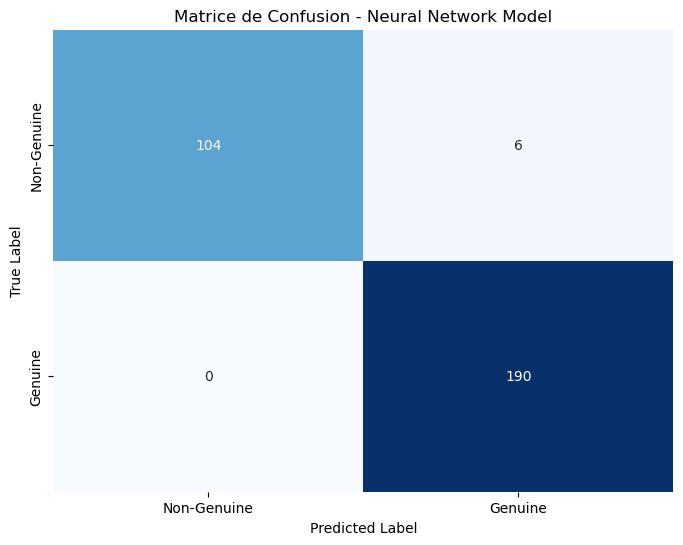

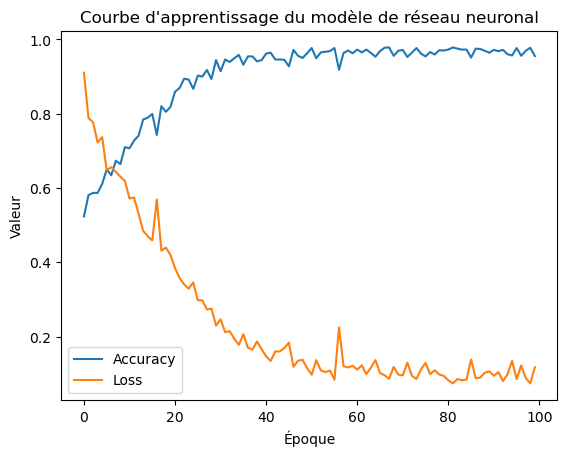

In [127]:
# Étape 1 : Créer et compiler le modèle
def create_neural_network(input_shape):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Créer le modèle
input_shape = X_train.shape[1]  # Nombre de caractéristiques
neural_model = create_neural_network(input_shape)

# Étape 2 : Entraîner le modèle
history = neural_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Étape 3 : Faire des prédictions
y_pred_prob = neural_model.predict(X_test).flatten()  # Probabilités prédites
y_pred_class = (y_pred_prob > 0.5).astype(int)  # Classes prédites

# Étape 4 : Évaluer le modèle
metrics = evaluate_model(y_test, y_pred_class, y_pred_prob, model_name='Neural Network Model')

# Convertir le dictionnaire de métriques en DataFrame
metrics_df = pd.DataFrame([metrics])

# Ajouter les résultats au tableau principal
metrics_table = pd.concat([metrics_table, metrics_df], ignore_index=True)

# Afficher le tableau des métriques
print(metrics_table)

# Étape 5 : Matrice de confusion
cm = confusion_matrix(y_test, y_pred_class)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Genuine", "Genuine"],
            yticklabels=["Non-Genuine", "Genuine"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de Confusion - Neural Network Model')
plt.show()

# Optionnel : Visualiser la courbe d'apprentissage
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.title('Courbe d\'apprentissage du modèle de réseau neuronal')
plt.xlabel('Époque')
plt.ylabel('Valeur')
plt.legend()
plt.show()

Augmenter la complexité du modèle / Ajouter des couches et des neurones :

10/10 [==============================] - 0s 998us/step
                      Model  Accuracy  Sensitivity  Specificity  Precision  \
0            Logistic Model  0.990000     0.994737     0.981818   0.989529   
1        Logistic Model AIC  0.990000     0.994737     0.981818   0.989529   
2   Logistic Model AIC Opti  0.996667     0.994737     1.000000   1.000000   
3  Random Forest Classifier  0.990000     1.000000     0.972727   0.984456   
4         Random Forest AIC  0.993333     1.000000     0.981818   0.989583   
5      Neural Network Model  0.980000     1.000000     0.945455   0.969388   
6    Neural Network Model_2  0.943333     1.000000     0.845455   0.917874   

   F1 Score  AUC Score  
0  0.992126   0.999856  
1  0.992126   0.999904  
2  0.997361   0.999904  
3  0.992167   0.999761  
4  0.994764   0.999713  
5  0.984456   0.999426  
6  0.957179   0.999617  


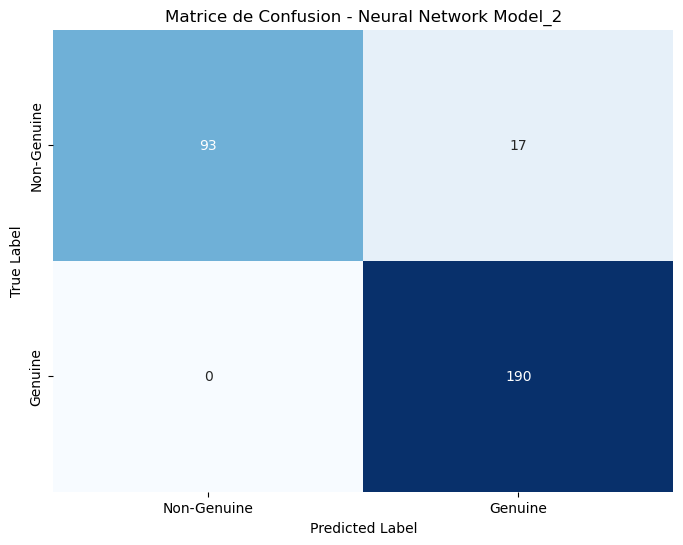

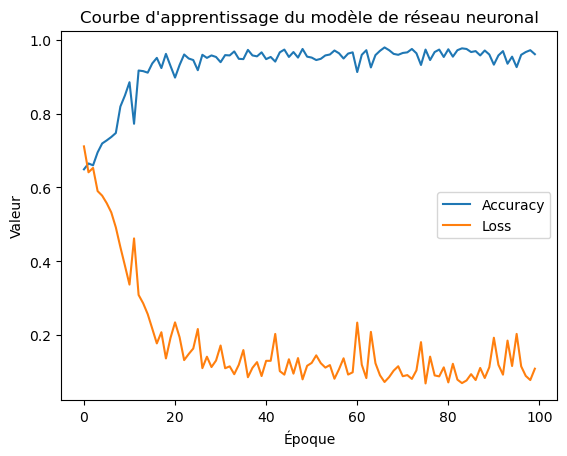

In [128]:
def create_neural_network_2(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))  # Augmenter à 64 neurones
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))  # Ajouter une couche supplémentaire
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Créer le modèle
input_shape = X_train.shape[1]  # Nombre de caractéristiques
neural_model = create_neural_network_2(input_shape)

# Étape 2 : Entraîner le modèle
history = neural_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Étape 3 : Faire des prédictions
y_pred_prob = neural_model.predict(X_test).flatten()  # Probabilités prédites
y_pred_class = (y_pred_prob > 0.5).astype(int)  # Classes prédites

# Étape 4 : Évaluer le modèle
metrics = evaluate_model(y_test, y_pred_class, y_pred_prob, model_name='Neural Network Model_2')

# Convertir le dictionnaire de métriques en DataFrame
metrics_df = pd.DataFrame([metrics])

# Ajouter les résultats au tableau principal
metrics_table = pd.concat([metrics_table, metrics_df], ignore_index=True)

# Afficher le tableau des métriques
print(metrics_table)

# Étape 5 : Matrice de confusion
cm = confusion_matrix(y_test, y_pred_class)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Genuine", "Genuine"],
            yticklabels=["Non-Genuine", "Genuine"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de Confusion - Neural Network Model_2')
plt.show()

# Optionnel : Visualiser la courbe d'apprentissage
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.title('Courbe d\'apprentissage du modèle de réseau neuronal')
plt.xlabel('Époque')
plt.ylabel('Valeur')
plt.legend()
plt.show()

2. Modifier le taux d’apprentissage / Utiliser un taux d’apprentissage personnalisé :

10/10 [==============================] - 0s 909us/step
                      Model  Accuracy  Sensitivity  Specificity  Precision  \
0            Logistic Model  0.990000     0.994737     0.981818   0.989529   
1        Logistic Model AIC  0.990000     0.994737     0.981818   0.989529   
2   Logistic Model AIC Opti  0.996667     0.994737     1.000000   1.000000   
3  Random Forest Classifier  0.990000     1.000000     0.972727   0.984456   
4         Random Forest AIC  0.993333     1.000000     0.981818   0.989583   
5      Neural Network Model  0.980000     1.000000     0.945455   0.969388   
6    Neural Network Model_2  0.943333     1.000000     0.845455   0.917874   
7    Neural Network Model_3  0.900000     1.000000     0.727273   0.863636   

   F1 Score  AUC Score  
0  0.992126   0.999856  
1  0.992126   0.999904  
2  0.997361   0.999904  
3  0.992167   0.999761  
4  0.994764   0.999713  
5  0.984456   0.999426  
6  0.957179   0.999617  
7  0.926829   0.994593  


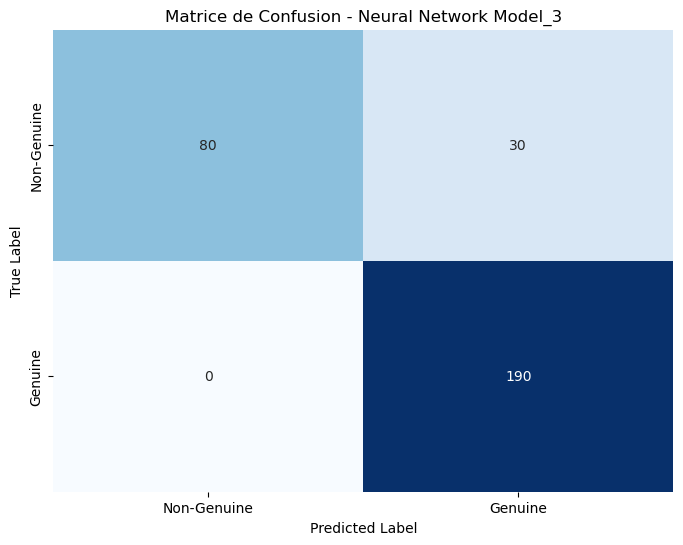

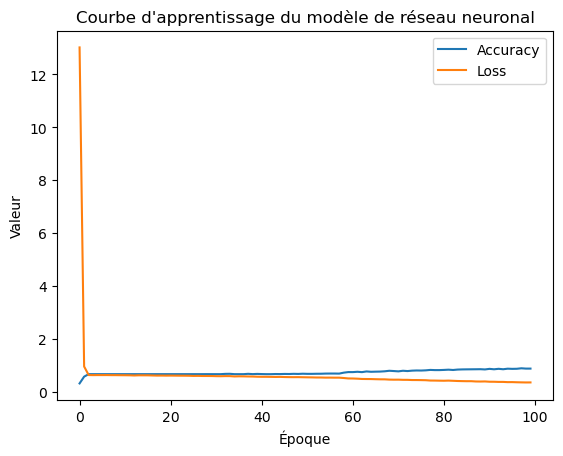

In [129]:
from keras.optimizers import Adam

# Créer le modèle avec un taux d'apprentissage personnalisé
def create_neural_network_3(input_shape):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=0.0001)  # Taux d'apprentissage plus bas
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Créer le modèle
input_shape = X_train.shape[1]  # Nombre de caractéristiques
neural_model = create_neural_network_3(input_shape)

# Étape 2 : Entraîner le modèle
history = neural_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Étape 3 : Faire des prédictions
y_pred_prob = neural_model.predict(X_test).flatten()  # Probabilités prédites
y_pred_class = (y_pred_prob > 0.5).astype(int)  # Classes prédites

# Étape 4 : Évaluer le modèle
metrics = evaluate_model(y_test, y_pred_class, y_pred_prob, model_name='Neural Network Model_3')

# Convertir le dictionnaire de métriques en DataFrame
metrics_df = pd.DataFrame([metrics])

# Ajouter les résultats au tableau principal
metrics_table = pd.concat([metrics_table, metrics_df], ignore_index=True)

# Afficher le tableau des métriques
print(metrics_table)

# Étape 5 : Matrice de confusion
cm = confusion_matrix(y_test, y_pred_class)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Genuine", "Genuine"],
            yticklabels=["Non-Genuine", "Genuine"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de Confusion - Neural Network Model_3')
plt.show()

# Optionnel : Visualiser la courbe d'apprentissage
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.title('Courbe d\'apprentissage du modèle de réseau neuronal')
plt.xlabel('Époque')
plt.ylabel('Valeur')
plt.legend()
plt.show()

3. Ajouter des techniques de régularisation / Utiliser la régularisation L2 ou le Dropout :

10/10 [==============================] - 0s 1ms/step
                      Model  Accuracy  Sensitivity  Specificity  Precision  \
0            Logistic Model  0.990000     0.994737     0.981818   0.989529   
1        Logistic Model AIC  0.990000     0.994737     0.981818   0.989529   
2   Logistic Model AIC Opti  0.996667     0.994737     1.000000   1.000000   
3  Random Forest Classifier  0.990000     1.000000     0.972727   0.984456   
4         Random Forest AIC  0.993333     1.000000     0.981818   0.989583   
5      Neural Network Model  0.980000     1.000000     0.945455   0.969388   
6    Neural Network Model_2  0.943333     1.000000     0.845455   0.917874   
7    Neural Network Model_3  0.900000     1.000000     0.727273   0.863636   
8    Neural Network Model_4  0.633333     1.000000     0.000000   0.633333   

   F1 Score  AUC Score  
0  0.992126   0.999856  
1  0.992126   0.999904  
2  0.997361   0.999904  
3  0.992167   0.999761  
4  0.994764   0.999713  
5  0.984456   0.

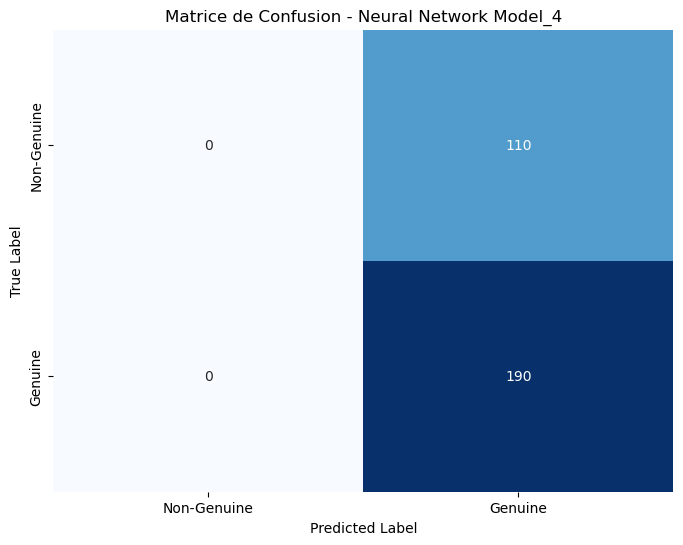

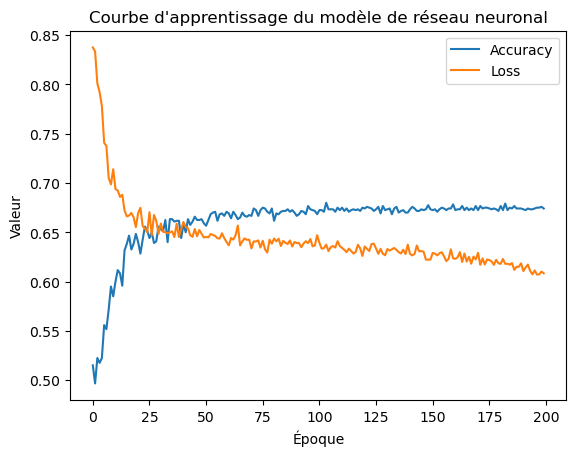

In [130]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

def create_neural_network_4(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Créer le modèle
input_shape = X_train.shape[1]  # Nombre de caractéristiques
neural_model = create_neural_network_4(input_shape)



# Étape 2 : Entraîner le modèle
history = neural_model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=0)

# Étape 3 : Faire des prédictions
y_pred_prob = neural_model.predict(X_test).flatten()  # Probabilités prédites
y_pred_class = (y_pred_prob > 0.5).astype(int)  # Classes prédites

# Étape 4 : Évaluer le modèle
metrics = evaluate_model(y_test, y_pred_class, y_pred_prob, model_name='Neural Network Model_4')

# Convertir le dictionnaire de métriques en DataFrame
metrics_df = pd.DataFrame([metrics])

# Ajouter les résultats au tableau principal
metrics_table = pd.concat([metrics_table, metrics_df], ignore_index=True)

# Afficher le tableau des métriques
print(metrics_table)

# Étape 5 : Matrice de confusion
cm = confusion_matrix(y_test, y_pred_class)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-Genuine", "Genuine"],
            yticklabels=["Non-Genuine", "Genuine"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de Confusion - Neural Network Model_4')
plt.show()

# Optionnel : Visualiser la courbe d'apprentissage
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.title('Courbe d\'apprentissage du modèle de réseau neuronal')
plt.xlabel('Époque')
plt.ylabel('Valeur')
plt.legend()
plt.show()

Résumé du Modèle de Réseau Neuronal

Le modèle de réseau neuronal développé se compose de trois couches avec une architecture optimisée comprenant 64 neurones dans la couche d'entrée, suivie d'une couche cachée de 32 neurones.  
Un Dropout de 50% a été intégré pour prévenir le surapprentissage, et une normalisation par lot a été appliquée pour améliorer la stabilité durant l'entraînement.  
Avec un taux d'apprentissage de 0.0001 et l'optimiseur Adam, le modèle a été entraîné pendant 200 époques.